# Problem Statement
X Education, an online education company catering to industry professionals, faces a significant challenge with its low lead conversion rate, currently standing at 30%. They attract potential customers through various online channels, including their website and referrals. To enhance their conversion rate, the company seeks to identify 'Hot Leads' – those with the highest potential for conversion into paying customers. By assigning lead scores to each prospect, the aim is to prioritize interactions with leads who are more likely to convert, thereby increasing the overall conversion rate towards the CEO's ambitious target of 80%. This initiative involves nurturing potential leads and improving the efficiency of the lead conversion process, ultimately resulting in a more effective and profitable customer acquisition strategy.

### Importing required libraries
Importing essential data science libraries for numerical computing, data manipulation, visualization, statistical analysis, machine learning preprocessing, feature selection, regression modeling, and performance metric evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

####  Supporting Functions :-

In [2]:
# Done for presentation purposes
# Set the background color for Seaborn plots
sns.set(style="whitegrid", rc={'axes.facecolor': '#fffef7', 'figure.facecolor': '#fffef7'})

# Set the background color for Matplotlib plots
plt.rcParams['figure.facecolor'] = '#fffef7'
plt.rcParams['axes.facecolor'] = '#fffef7'

# Function to display basic information from dataframe (head, info etc)
def get_initial_data_from_dataFrame (df):
    print("\n Dataframe head:-")
    print(df.head())
    print("\n Dataframe tail:-")
    print(df.tail())
    print("\n Dataframe info:-")
    print(df.info(verbose=True))
    print("\n Dataframe description:-")
    print(df.describe())

# Function to display missing values
def list_missing_values (df):
    missing_values = df.isnull().sum()
    missing_values_percentage = 100 * missing_values / len(df)
    print('Percentage of missing values in each column:')
    print(missing_values_percentage[missing_values_percentage > 0].sort_values(ascending=False))
    return missing_values_percentage


# Function to plot countplot
def plot_countplot(df, col, title=None, hue=None, palette = 'magma'):
    sns.set_style('whitegrid')
    sns.set_context('talk')
    temp = pd.Series(data=hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    fig.set_size_inches(width, 8)
    plt.xticks(rotation=45)
    plt.yscale('log')
    if title==None:
        title = col  + " Visualized"
    plt.title(title)
    ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, hue=hue, palette=palette)
    # Annotate bars with count
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')



## Step 1: Data Loading and Initial Inspection

We'll start by loading the dataset and performing an initial inspection to understand its structure, variables, and any immediate data quality issues.

In [3]:
# Load dataset
lead_data = pd.read_csv("Leads.csv")
get_initial_data_from_dataFrame(lead_data)



 Dataframe head:-
                            Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit  ...  \
0           

#### Initial Inspection

Columns: The dataset consists of 37 columns, including key variables such as 'Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source', 'Converted', and several others.
First Few Rows: The initial rows show a mix of categorical and numerical data, with various attributes of the leads.

#### Data Summary

Total Entries: 9240 rows.
Missing Values: Some columns have missing values. For example, 'Lead Source', 'TotalVisits', 'Page Views Per Visit', 'Last Activity', 'Country', etc., have fewer non-null entries than the total number of rows.
Data Types: A mix of object (categorical), int64, and float64 types.

## Step 2: Data Cleaning and Preprocessing
The next step is to address missing values, convert data types where necessary, and handle categorical variables, particularly the 'Select' level in them. Let's proceed with these actions.

In [4]:
missing_values_percent = list_missing_values(lead_data)

Percentage of missing values in each column:
Lead Quality                                     51.590909
Asymmetrique Profile Score                       45.649351
Asymmetrique Activity Score                      45.649351
Asymmetrique Profile Index                       45.649351
Asymmetrique Activity Index                      45.649351
Tags                                             36.287879
Lead Profile                                     29.318182
What matters most to you in choosing a course    29.318182
What is your current occupation                  29.112554
Country                                          26.634199
How did you hear about X Education               23.885281
Specialization                                   15.562771
City                                             15.367965
TotalVisits                                       1.482684
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Lead Source

We will now remove all the items with missing values greater than 30% and handle other columns (City, What is your current occupation  etc) individually by visualizing them and making imputations where necessary. 

In [5]:
# Columns with a high percentage of missing values (threshold set to 30% for this analysis)
columns_to_drop = missing_values_percent[missing_values_percent > 30].index
print("Columns which are going to be dropped")
print(columns_to_drop)
# Dropping columns with a high percentage of missing values
lead_data.drop(columns=columns_to_drop,inplace=True)
lead_data.shape

Columns which are going to be dropped
Index(['Tags', 'Lead Quality', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score'],
      dtype='object')


(9240, 31)

We will now focus on visualizing and finding insights on the columns which still have significant missing values. 

Percentage of missing values in each column:
What matters most to you in choosing a course    29.318182
Lead Profile                                     29.318182
What is your current occupation                  29.112554
Country                                          26.634199
How did you hear about X Education               23.885281
Specialization                                   15.562771
City                                             15.367965
TotalVisits                                       1.482684
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Lead Source                                       0.389610
dtype: float64
Index(['Country', 'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Lead Profile',
       'City'],
      dtype='object')


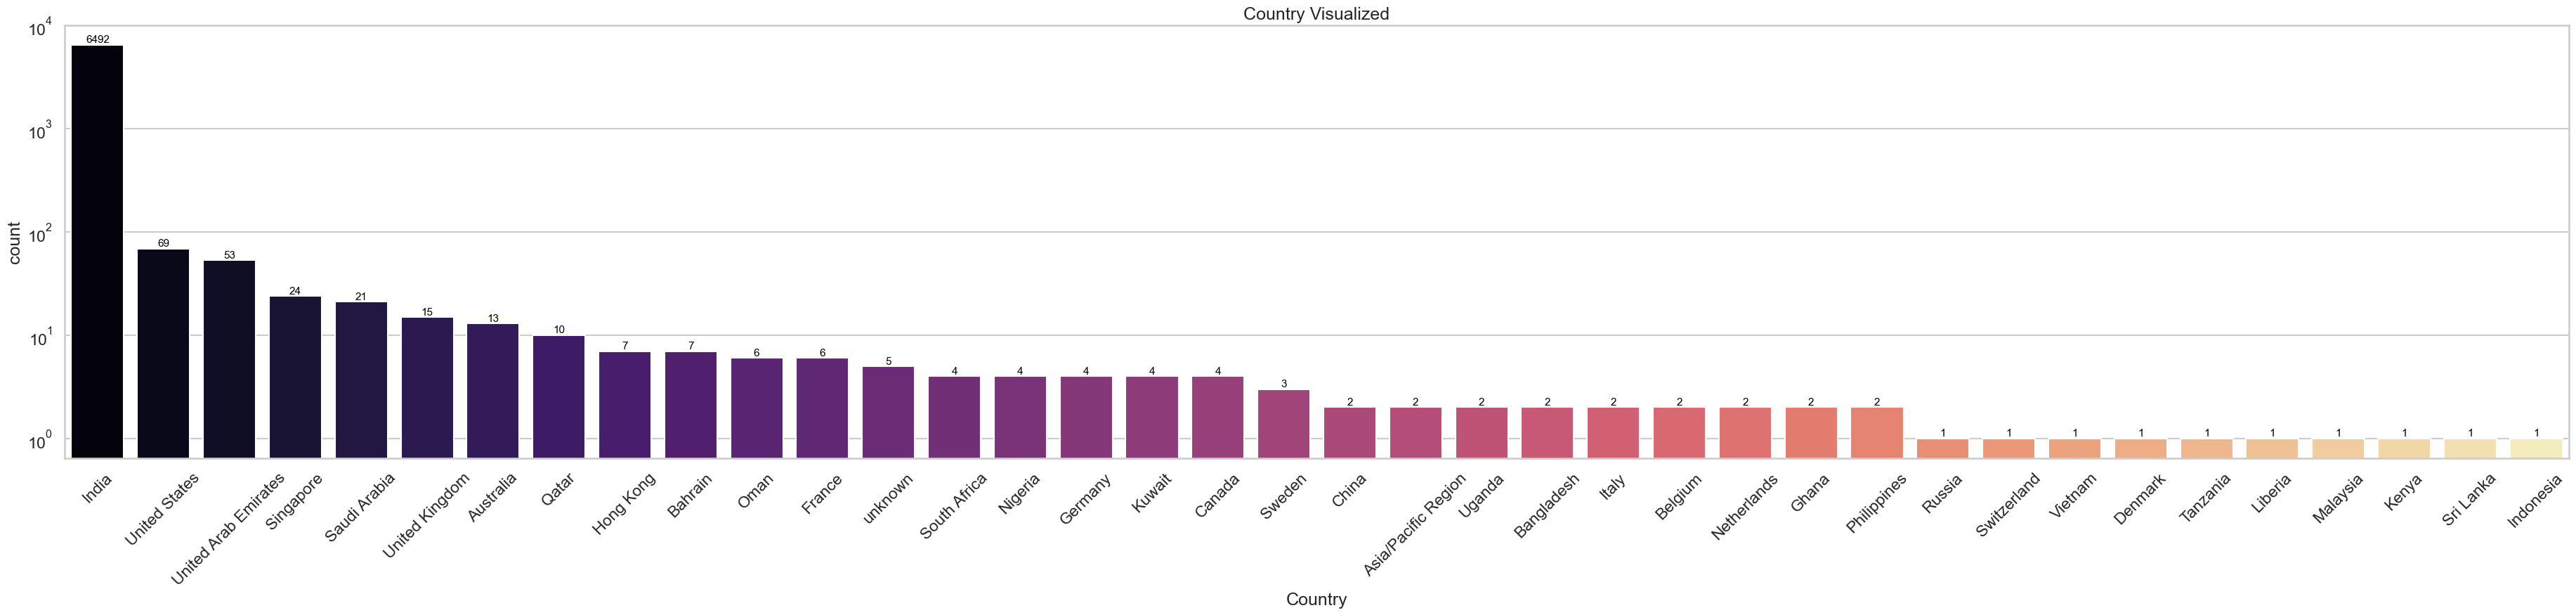

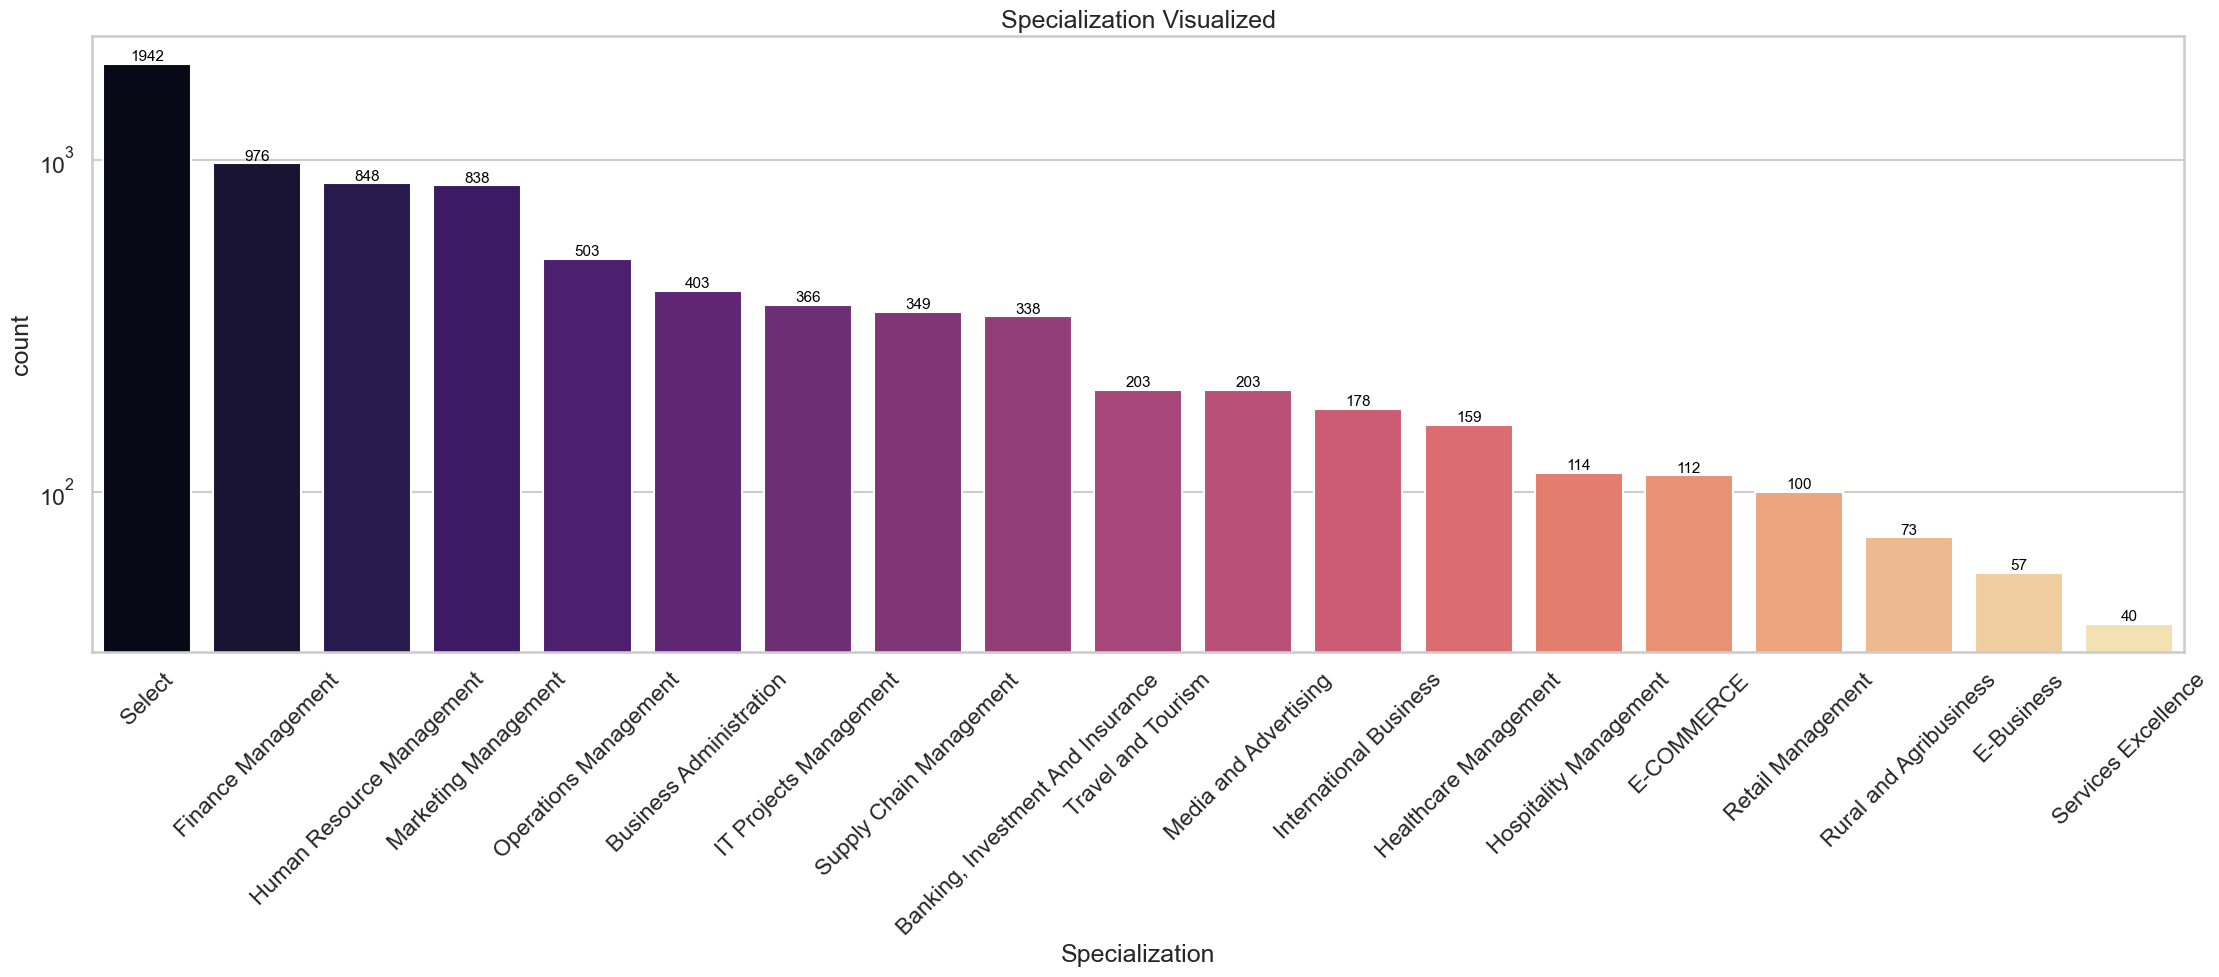

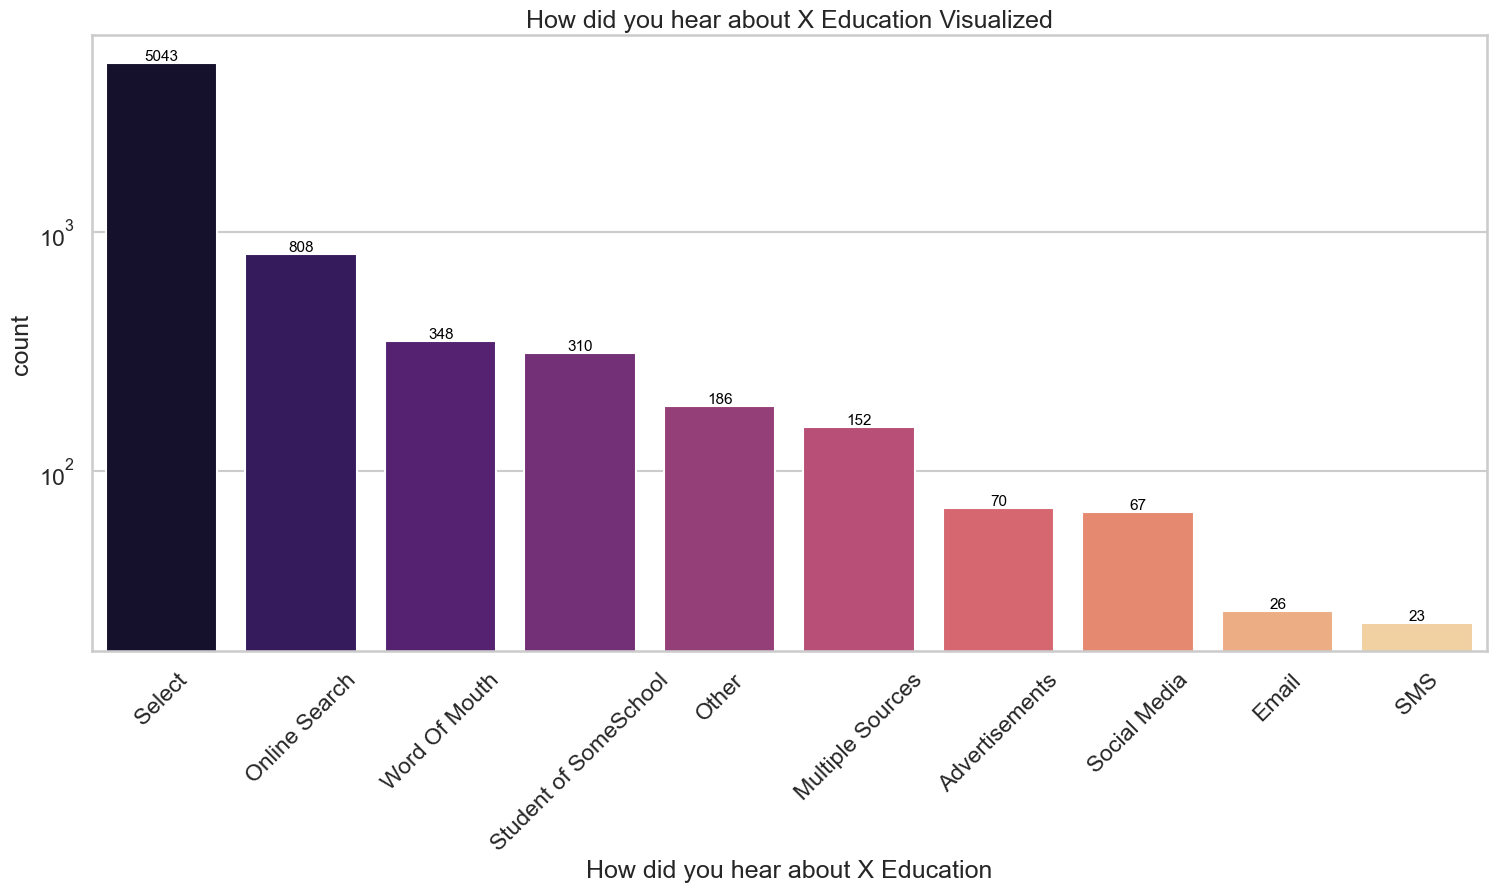

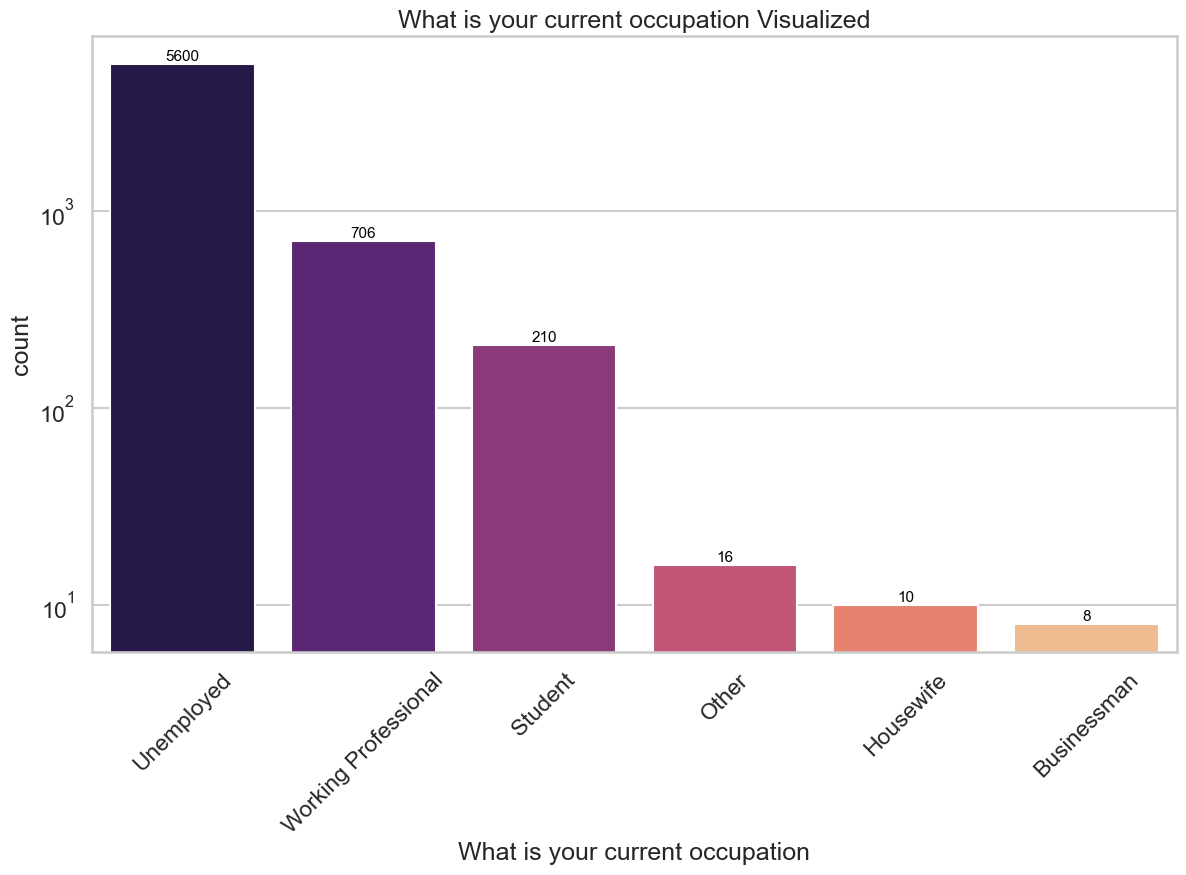

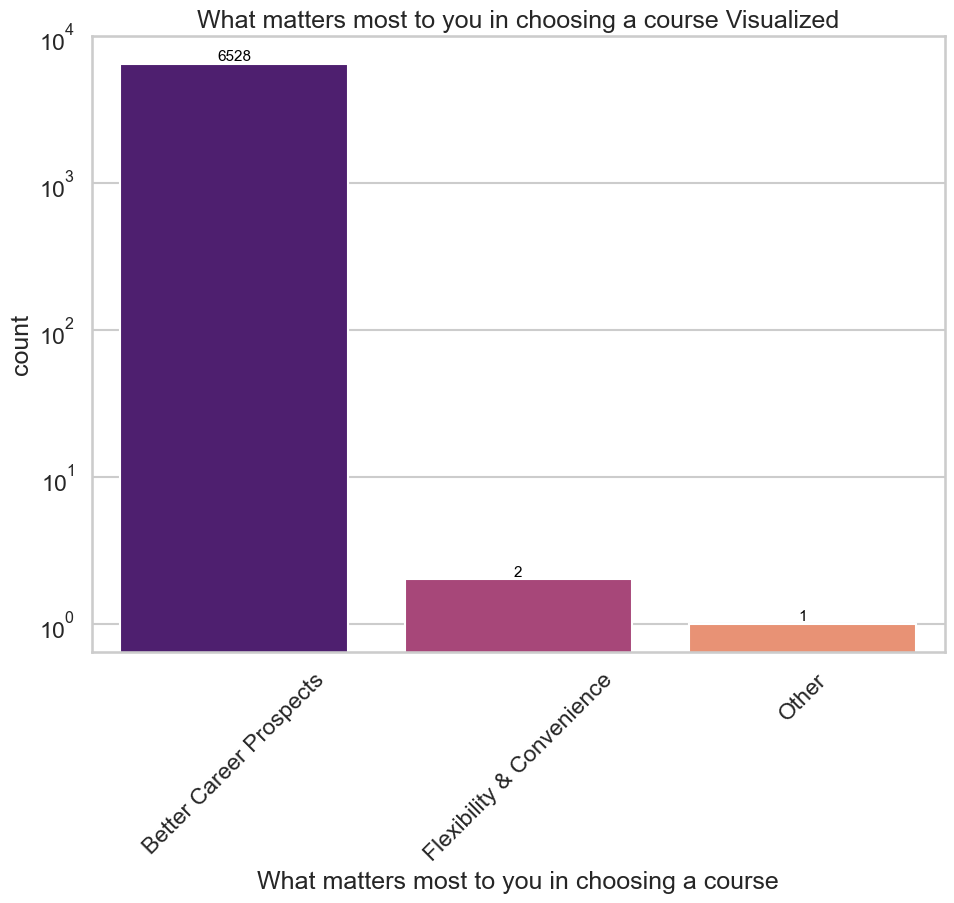

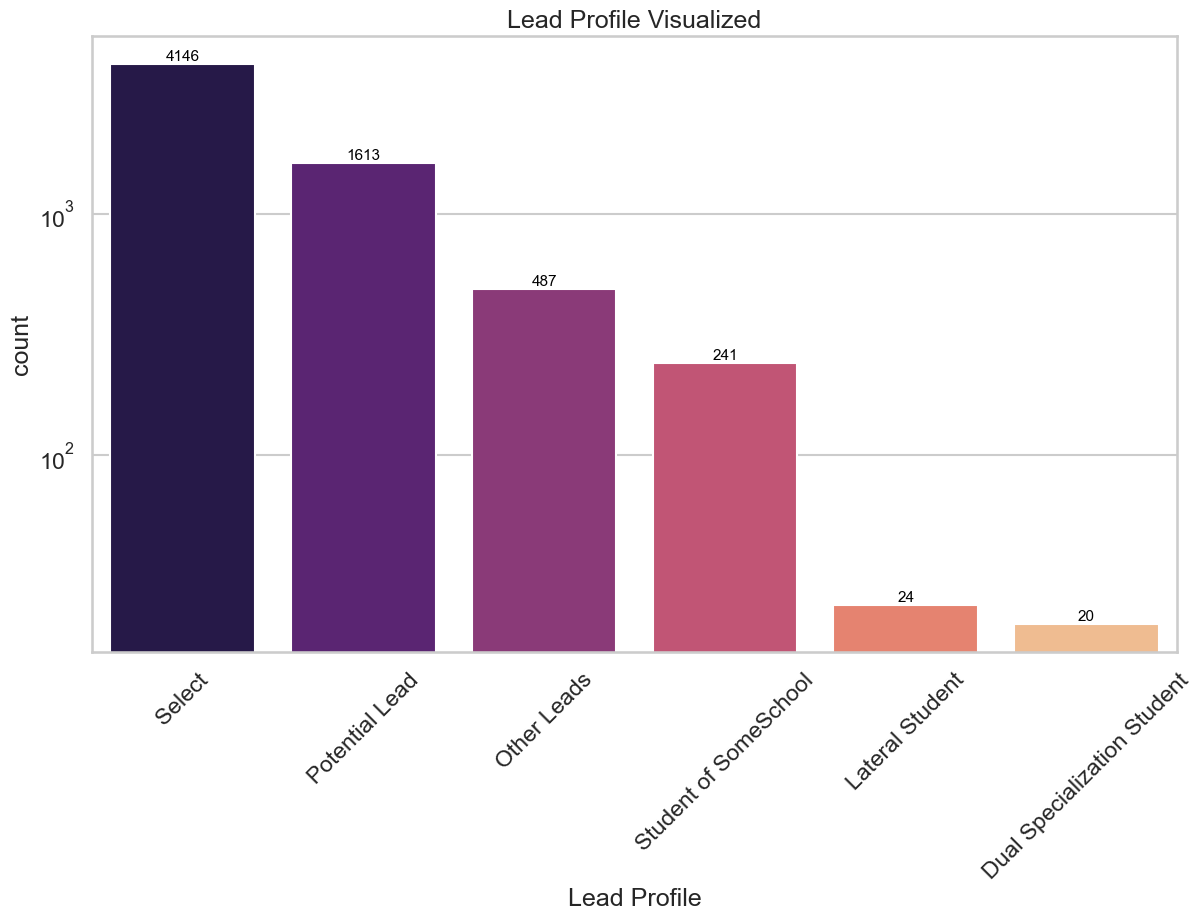

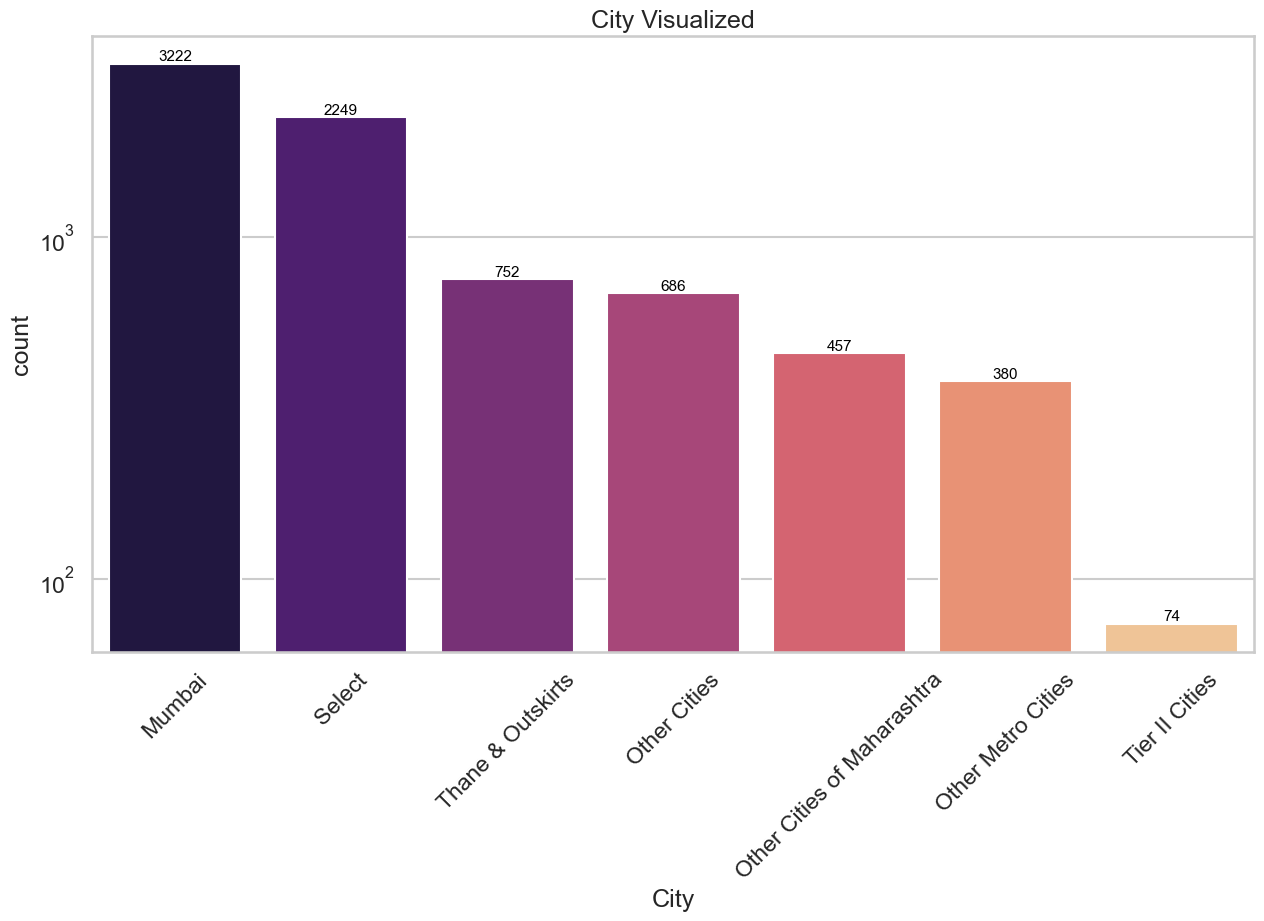

In [6]:
column_with_missing_values = list_missing_values(lead_data)
columns_to_check = column_with_missing_values[column_with_missing_values > 2].index
print(columns_to_check)
for column in columns_to_check:
    plot_countplot(lead_data, column)

### Insights from countplots analysis:

* 'How did you hear about X Education': We observed the presence of a 'Others' value, suggesting that we can replace missing values with this category.

* 'Specialization': This column has many missing values, possibly because leads might be students, have no specialization, or their specialization isn't listed. To address this, we can create an 'Others' category.

* 'What matters most to you in choosing a course': This column appears highly skewed, and as a result, we recommend removing it from our analysis.

* 'What is your current occupation': The majority of values are 'Unemployed,' so we can impute missing values in this column with 'Unemployed.'

* 'Country': Although this column is skewed, it provides essential lead information. Given that most values are 'India,' we can impute missing values with 'India.'

* 'City': As 'Mumbai' is the most frequent entry, we can impute missing values in this column with 'Mumbai.'

* 'Lead Profile': As 'Other Leads' is available, we can impute missing values in this column with 'Other Leads'

#### Filling the missing values

In [7]:
# Fill missing values
lead_data['Specialization'].fillna('Others', inplace=True)
lead_data['How did you hear about X Education'].fillna('Others', inplace=True)
lead_data['What is your current occupation'].fillna('Unemployed', inplace=True)
lead_data['Country'].fillna('India', inplace=True)
lead_data['City'].fillna('Mumbai', inplace=True)
lead_data['Lead Profile'].fillna('Other Leads', inplace=True)
lead_data.drop('What matters most to you in choosing a course',axis=1,inplace=True)
list_missing_values(lead_data)
lead_data.shape

Percentage of missing values in each column:
TotalVisits             1.482684
Page Views Per Visit    1.482684
Last Activity           1.114719
Lead Source             0.389610
dtype: float64


(9240, 30)

Since the missing values are insignificant, we can drop the rows associated with them.

In [8]:
# Percentage of rows retained 
previous_rows = len(lead_data.index)

lead_data.dropna(inplace=True)
print("Percentage of values retained")
(len(lead_data.index)/previous_rows)*100

Percentage of values retained


98.2034632034632

## Step 3: Exploratory Data Analysis

We will check the distribution of leads, look at univariate and bivariate analysis, then generate insights on what factors influence succesful lead conversion. 

### 3.1: Distribution of Target Variable ('Converted')

Converted
0    62.144589
1    37.855411
Name: proportion, dtype: float64


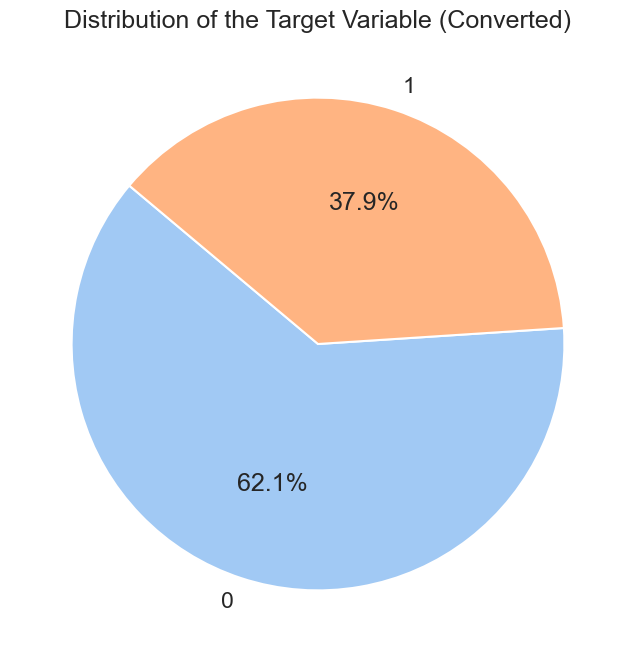

In [9]:
target_variable_distribution = lead_data['Converted'].value_counts(normalize=True) * 100
print(target_variable_distribution)
plt.figure(figsize=(8, 8))
plt.pie(target_variable_distribution, labels=target_variable_distribution.index, autopct='%1.1f%%', startangle=140,  colors=sns.color_palette('pastel'))
plt.title('Distribution of the Target Variable (Converted)')
sns.set_style("whitegrid")
plt.show()

Target Variable ('Converted') Distribution:

    Unconverted (0): 61.46%
    Converted (1): 38.54%
    This indicates a moderate imbalance in the target variable.



### 3.2: Analysis of object columns

Lead Origin
Lead Source
Do Not Email
Do Not Call
Last Activity
Country
Specialization
How did you hear about X Education
What is your current occupation
Search
Magazine
Newspaper Article
X Education Forums
Newspaper
Digital Advertisement
Through Recommendations
Receive More Updates About Our Courses
Update me on Supply Chain Content
Get updates on DM Content
Lead Profile
City
I agree to pay the amount through cheque
A free copy of Mastering The Interview
Last Notable Activity


(9074, 30)

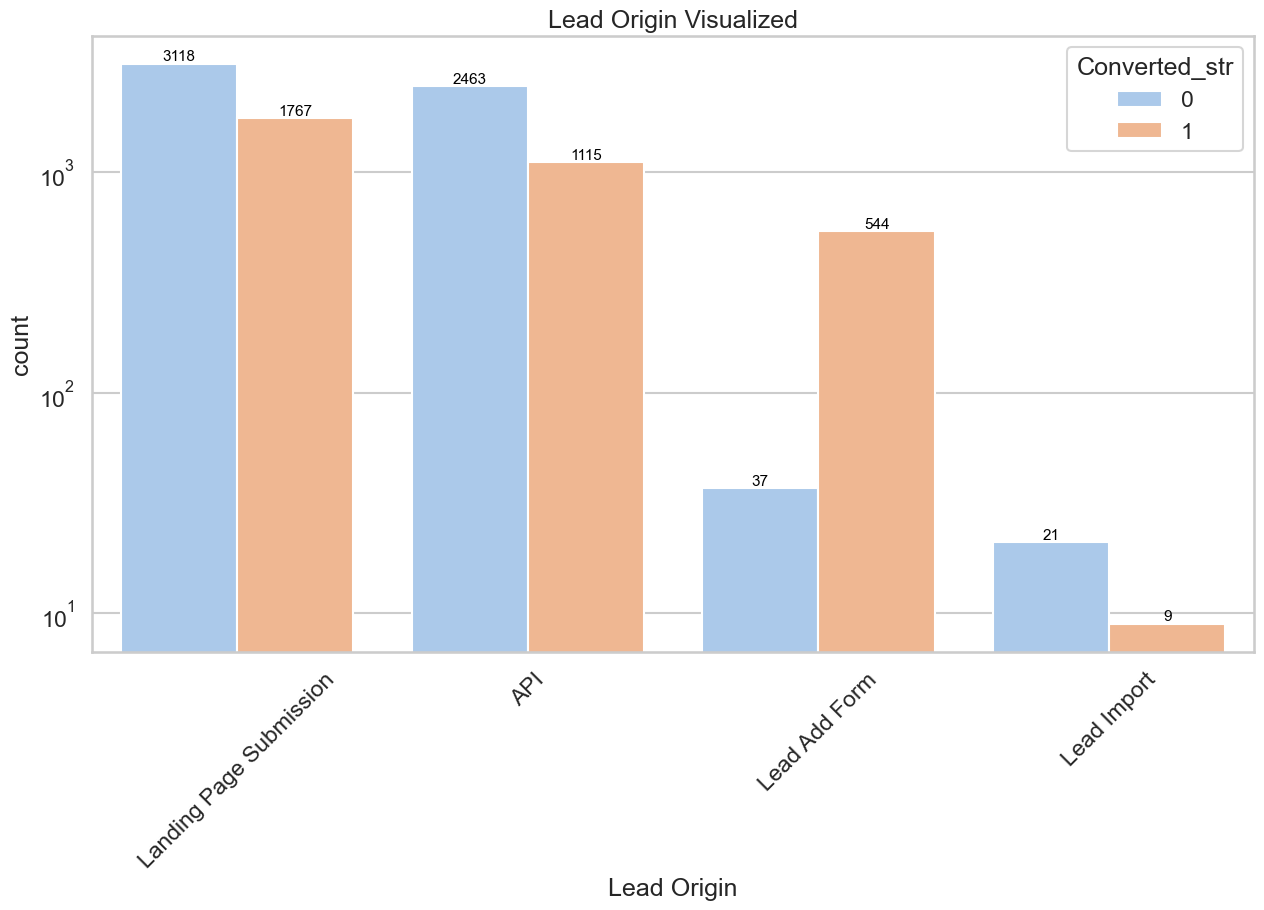

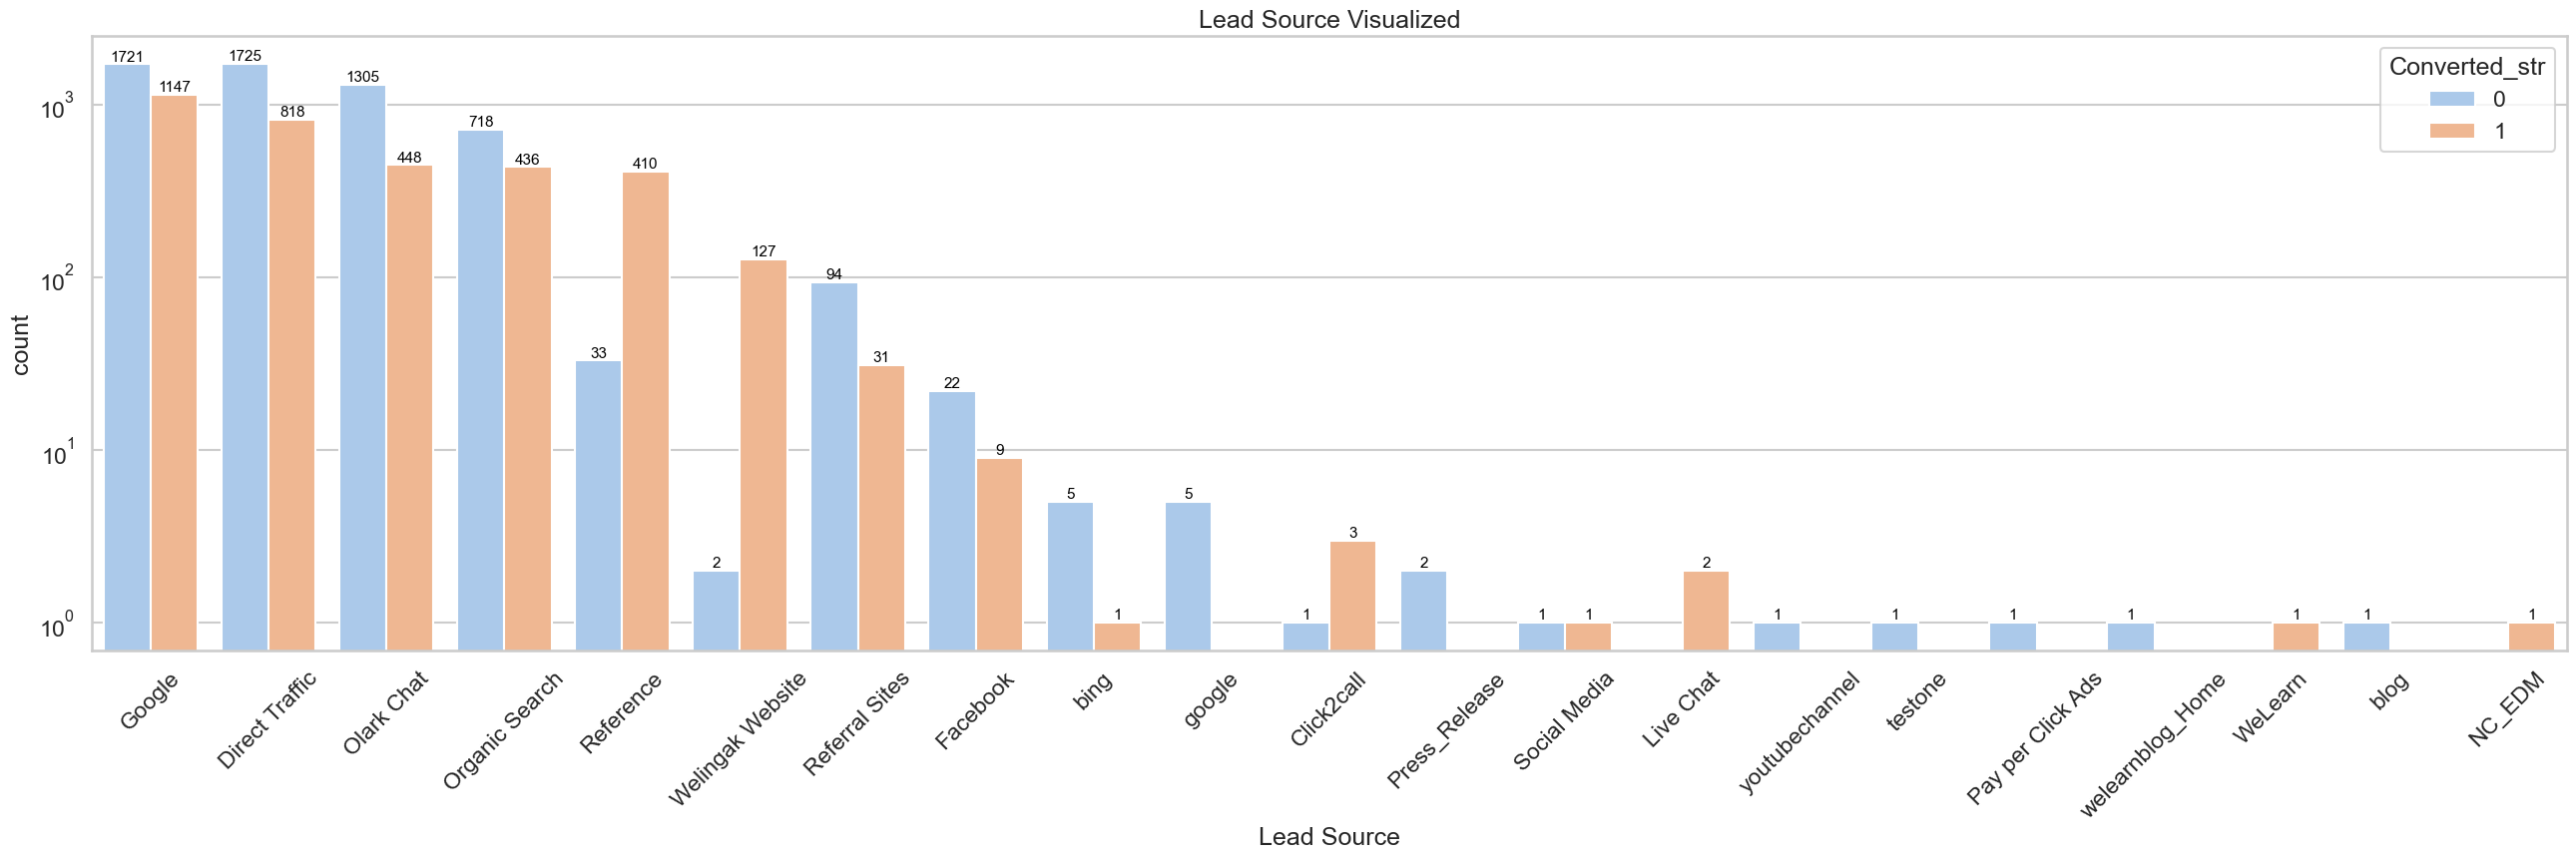

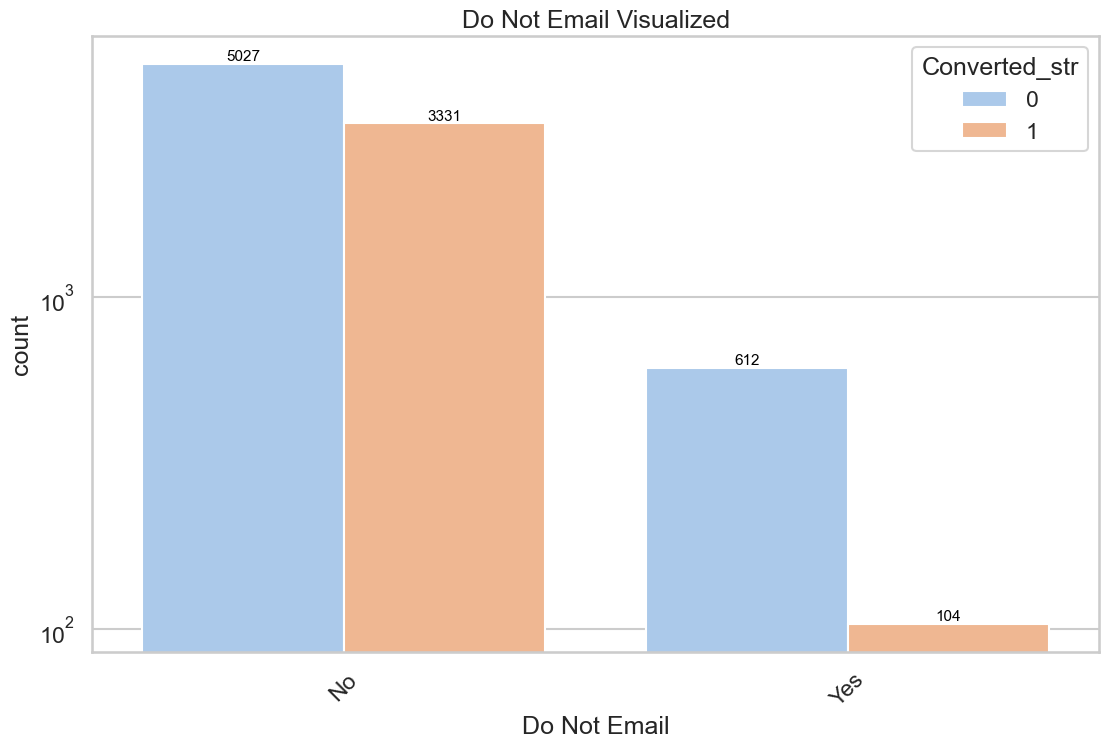

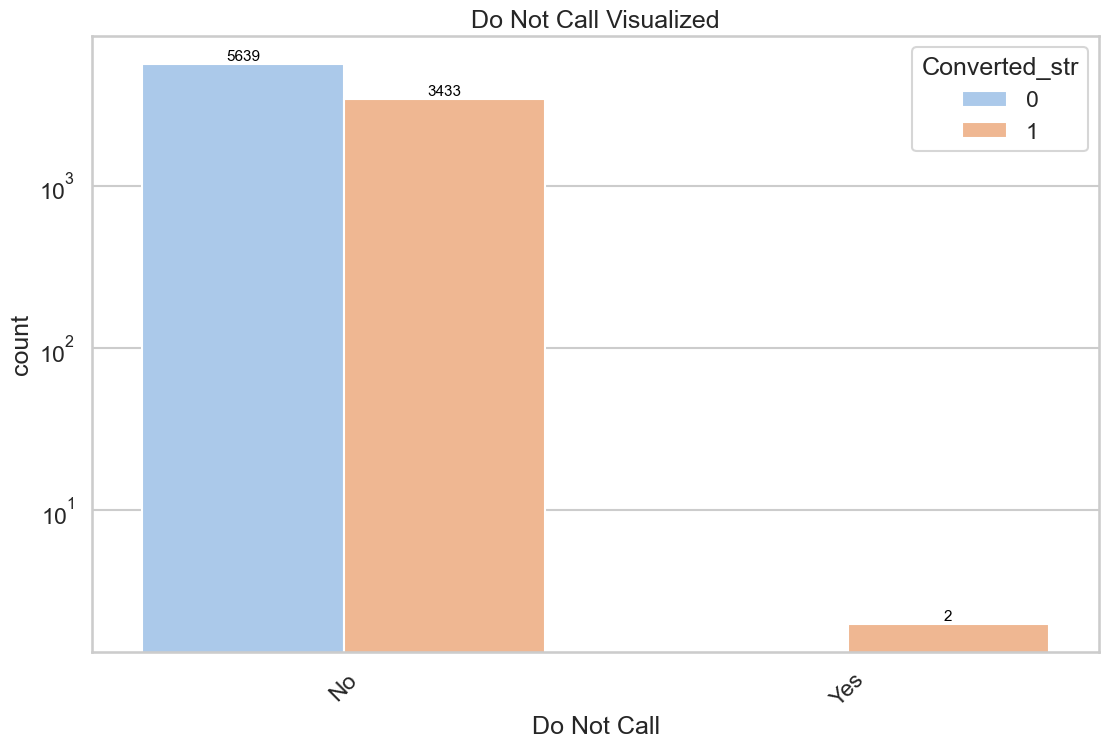

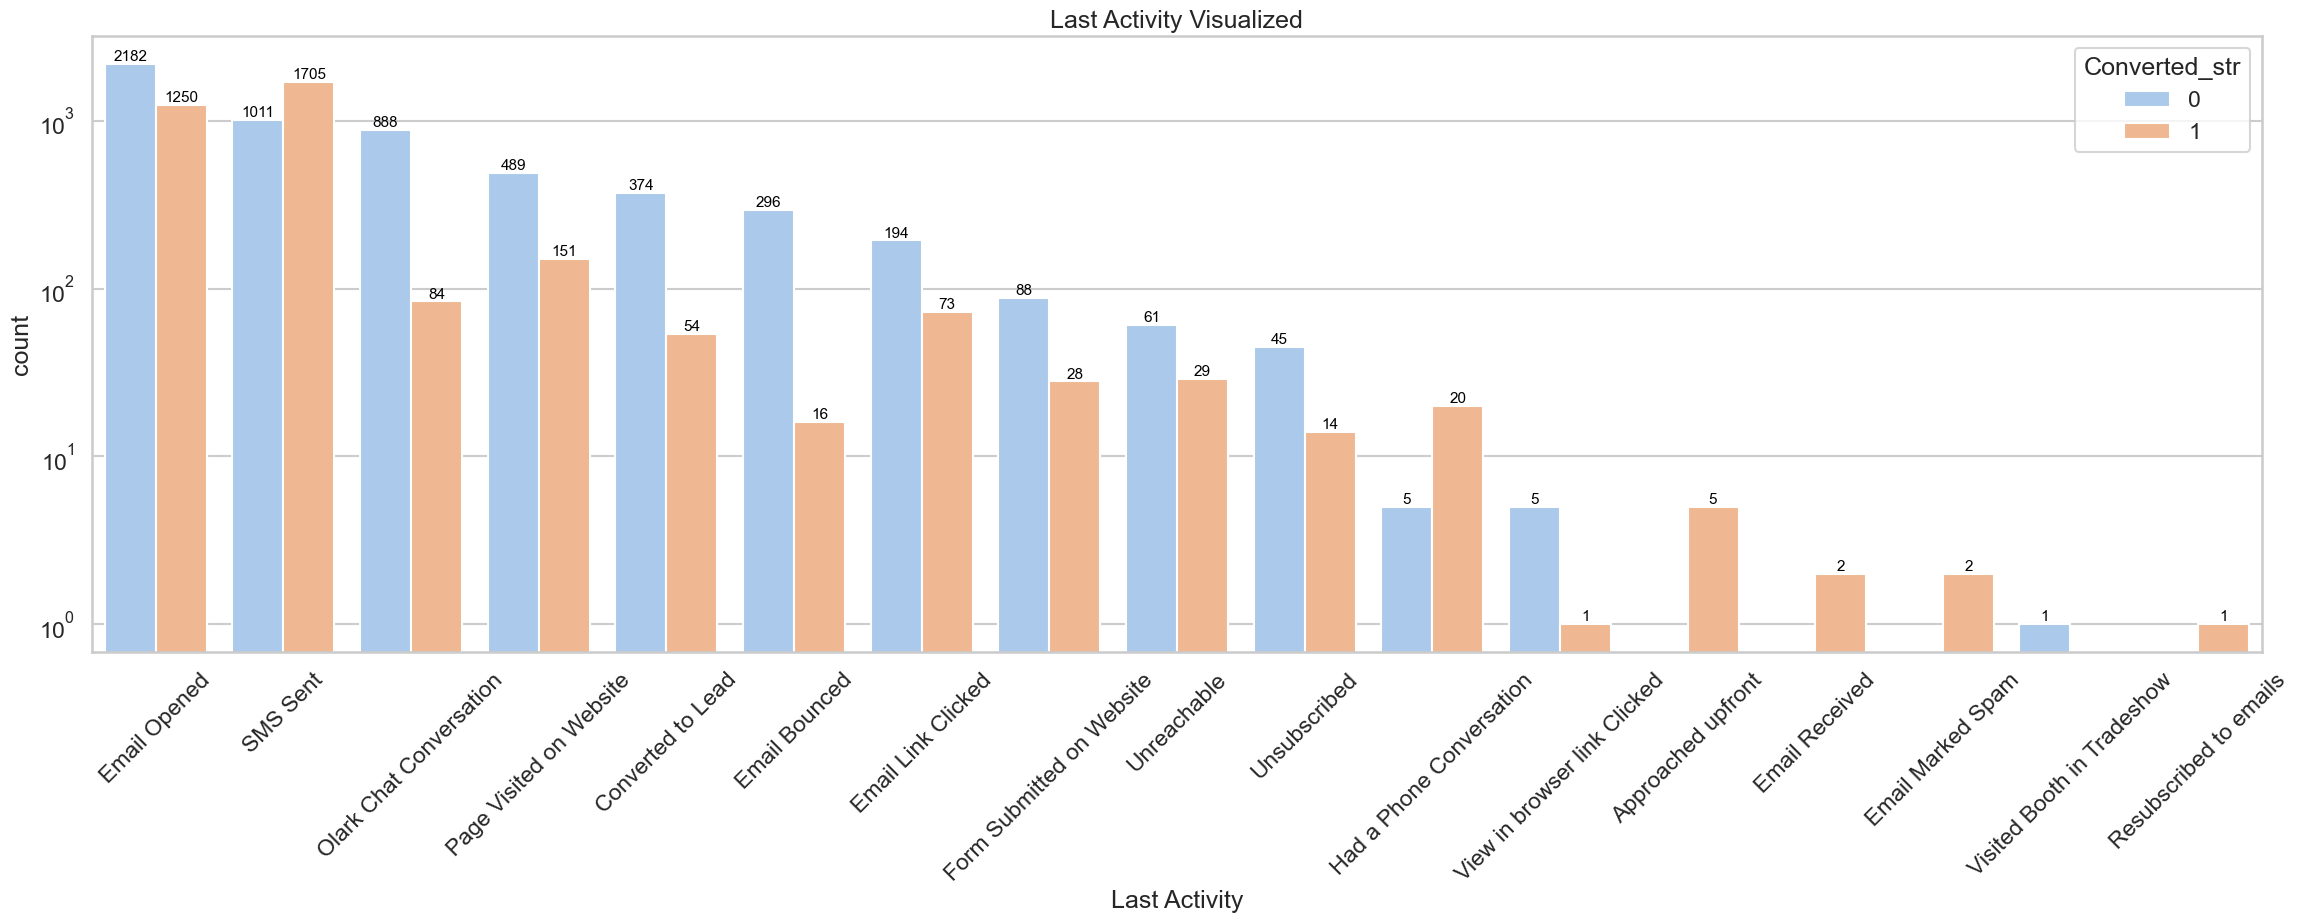

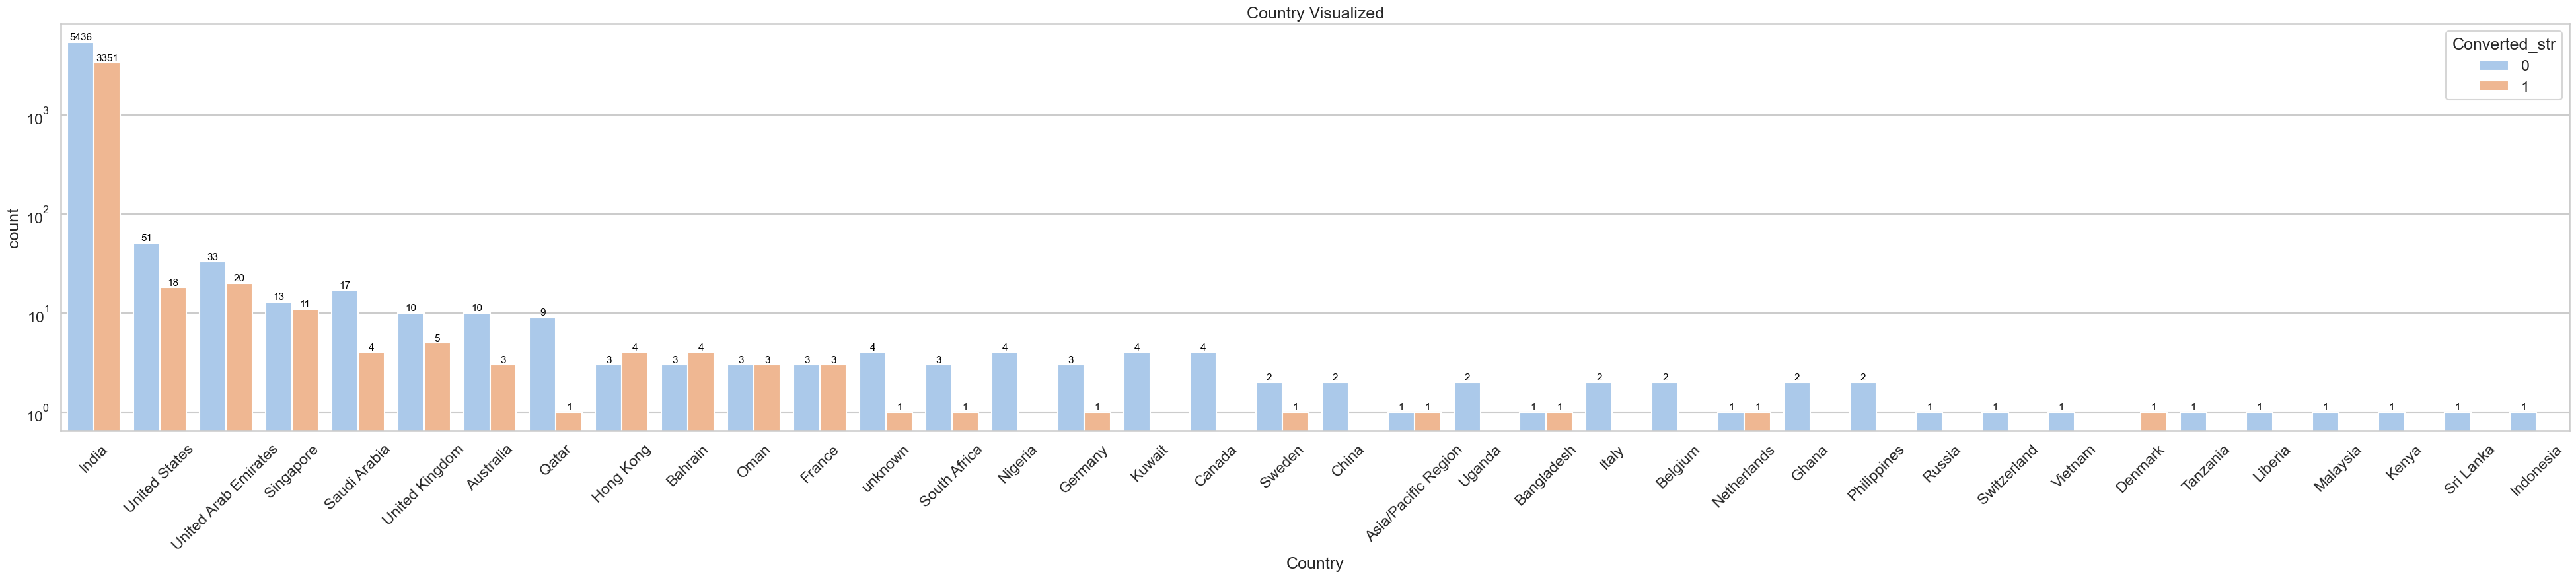

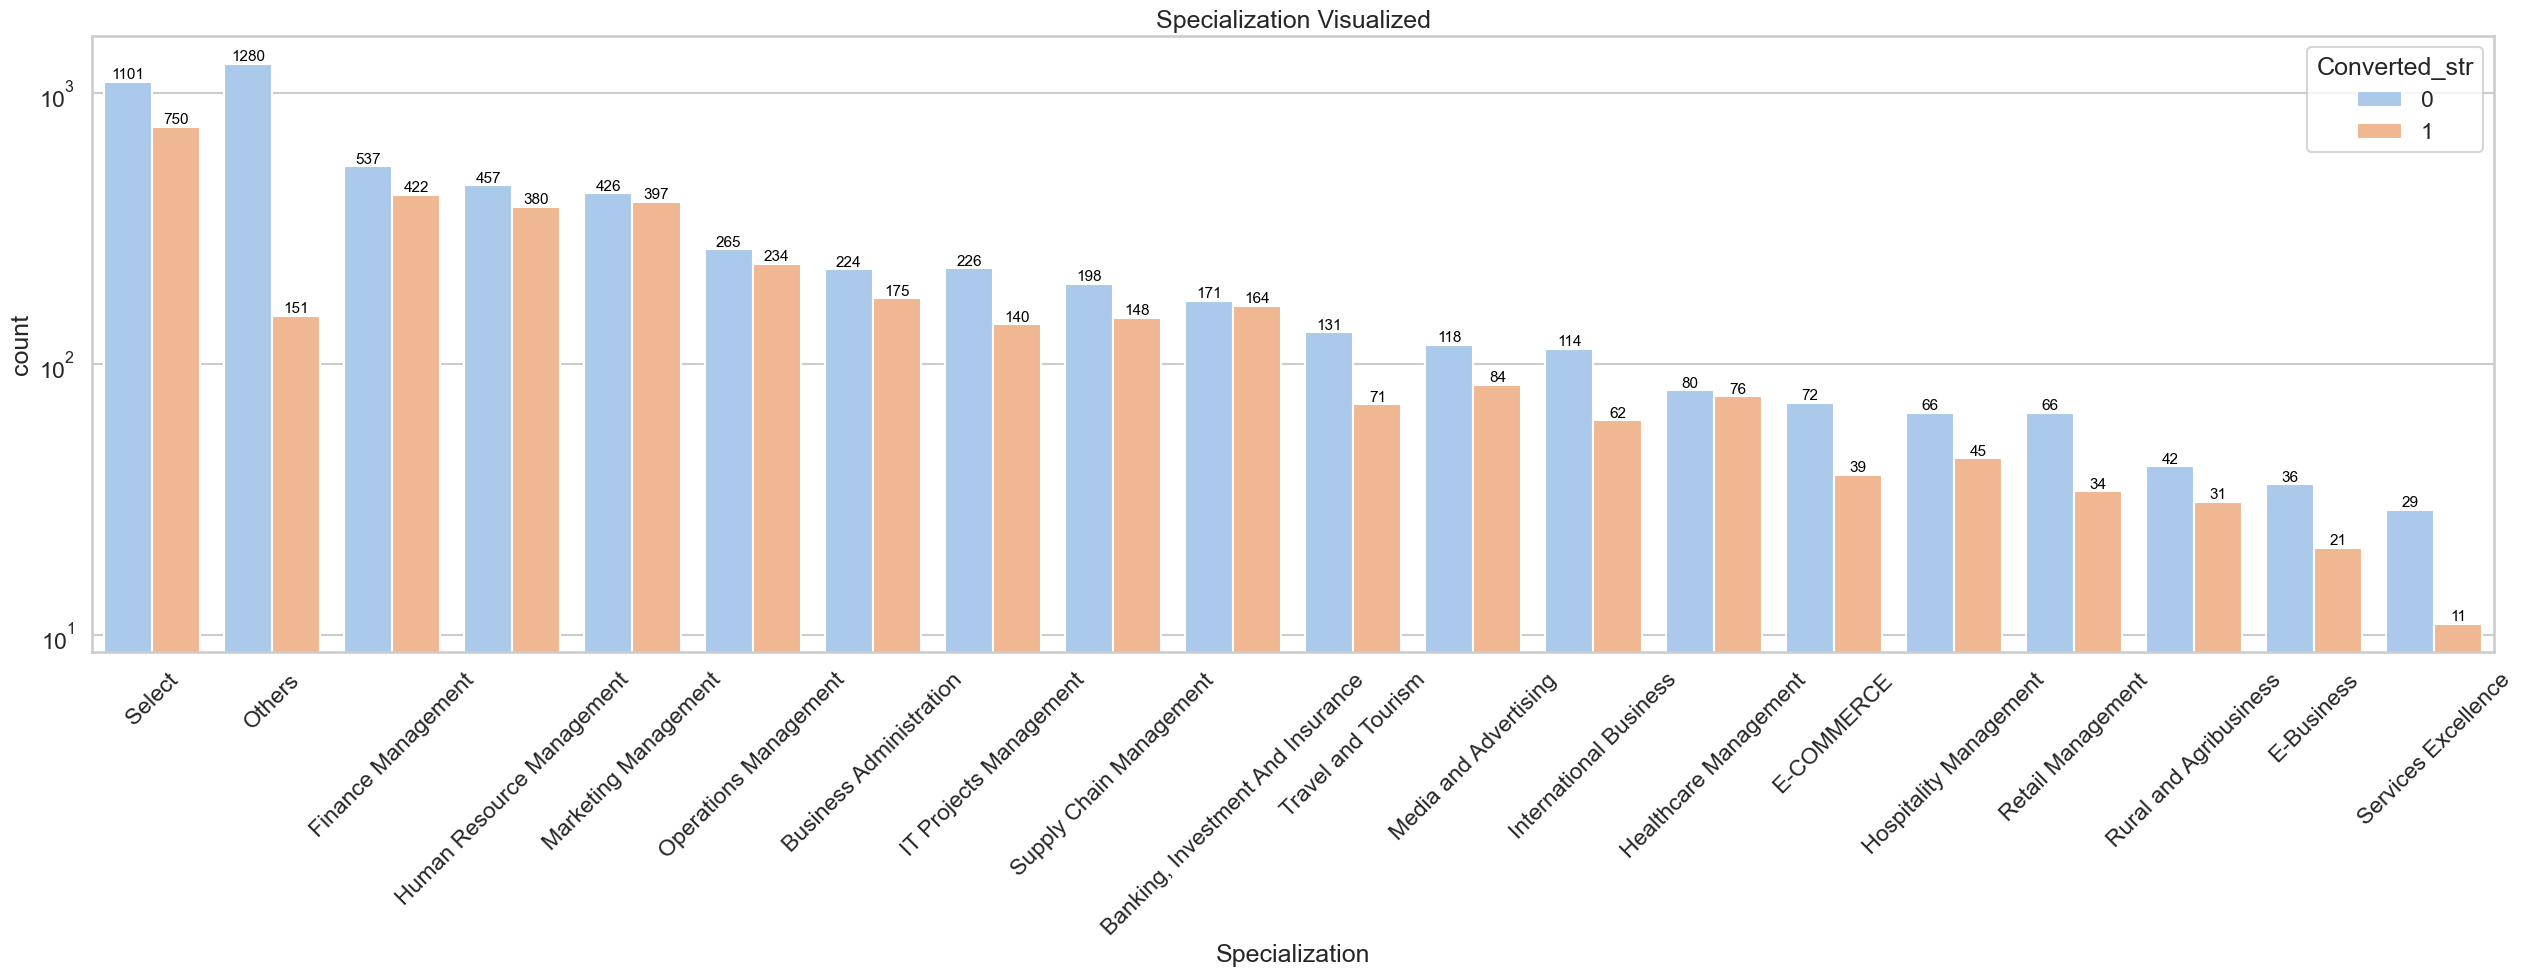

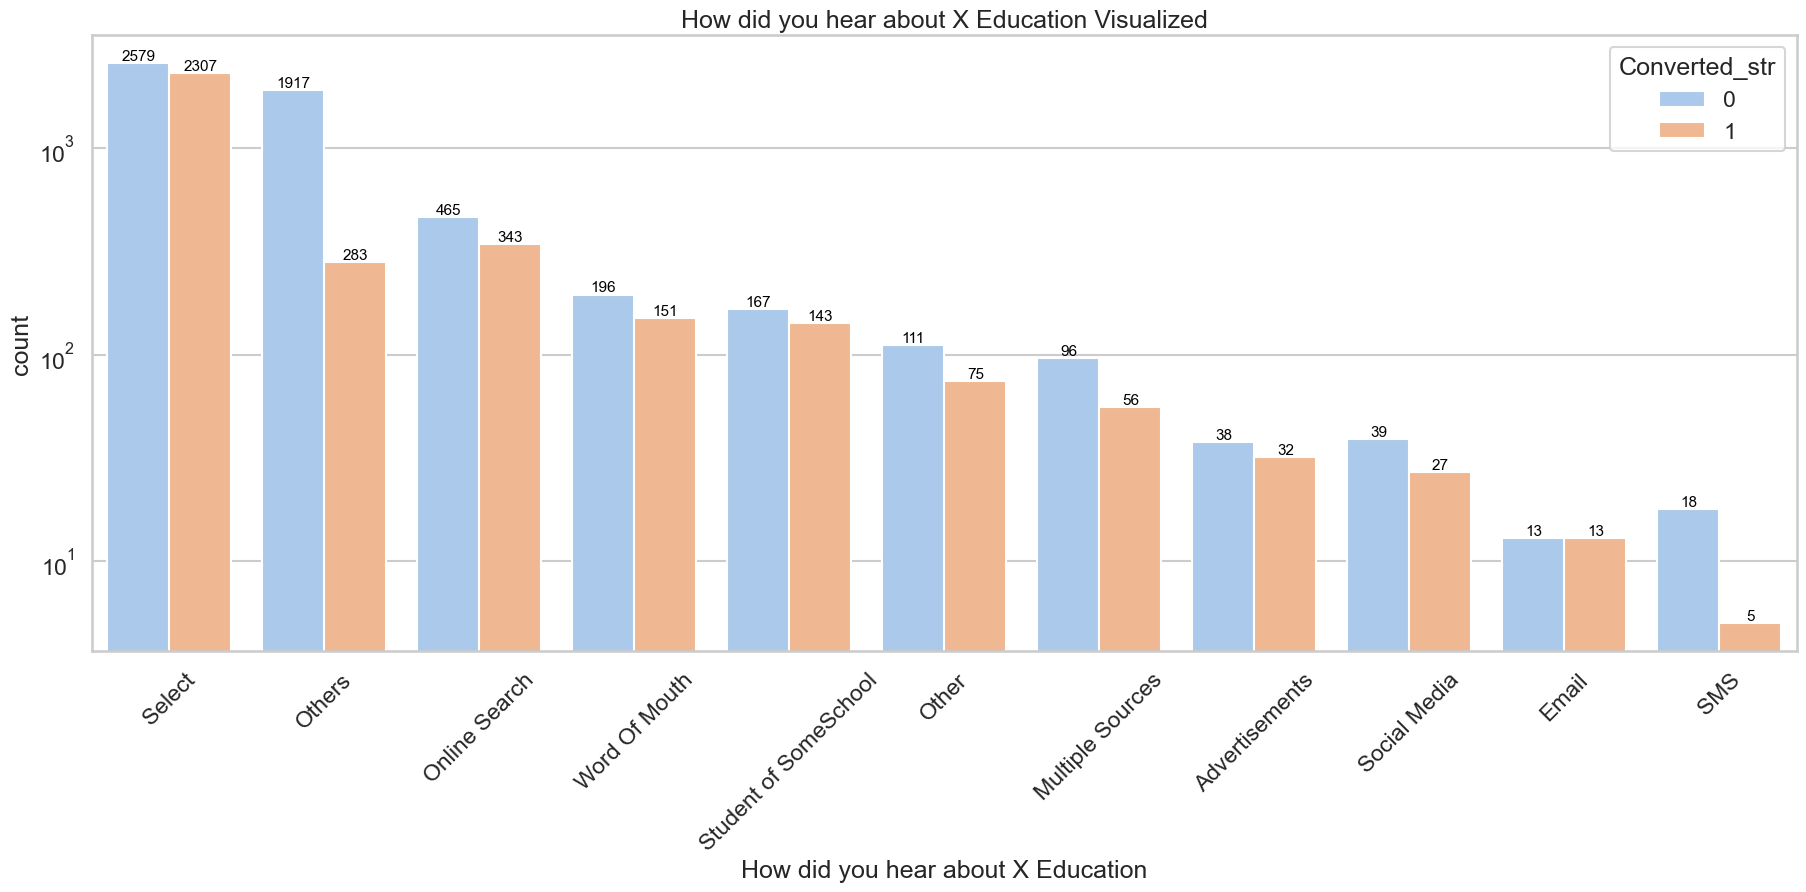

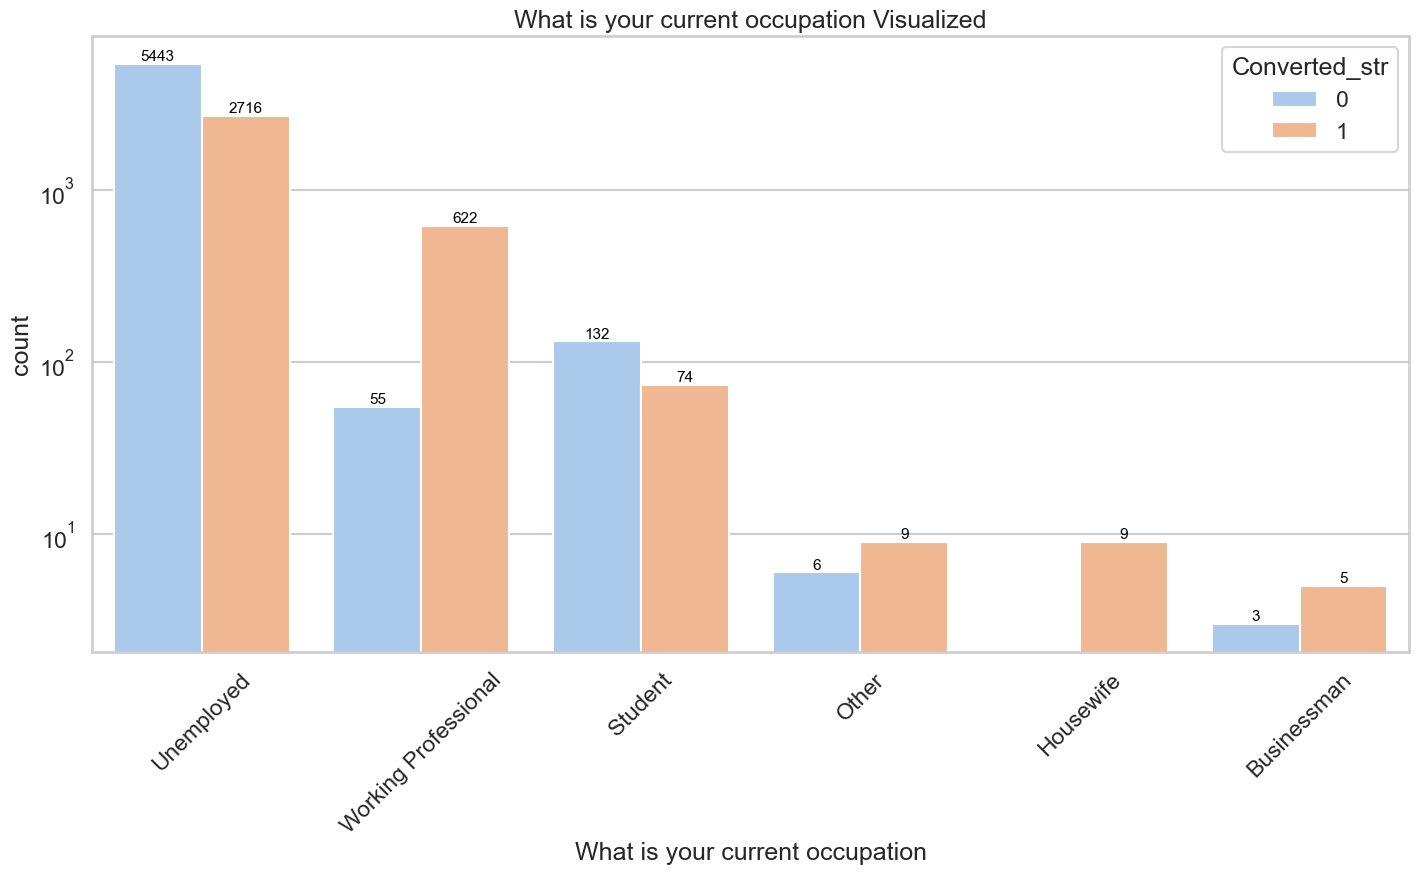

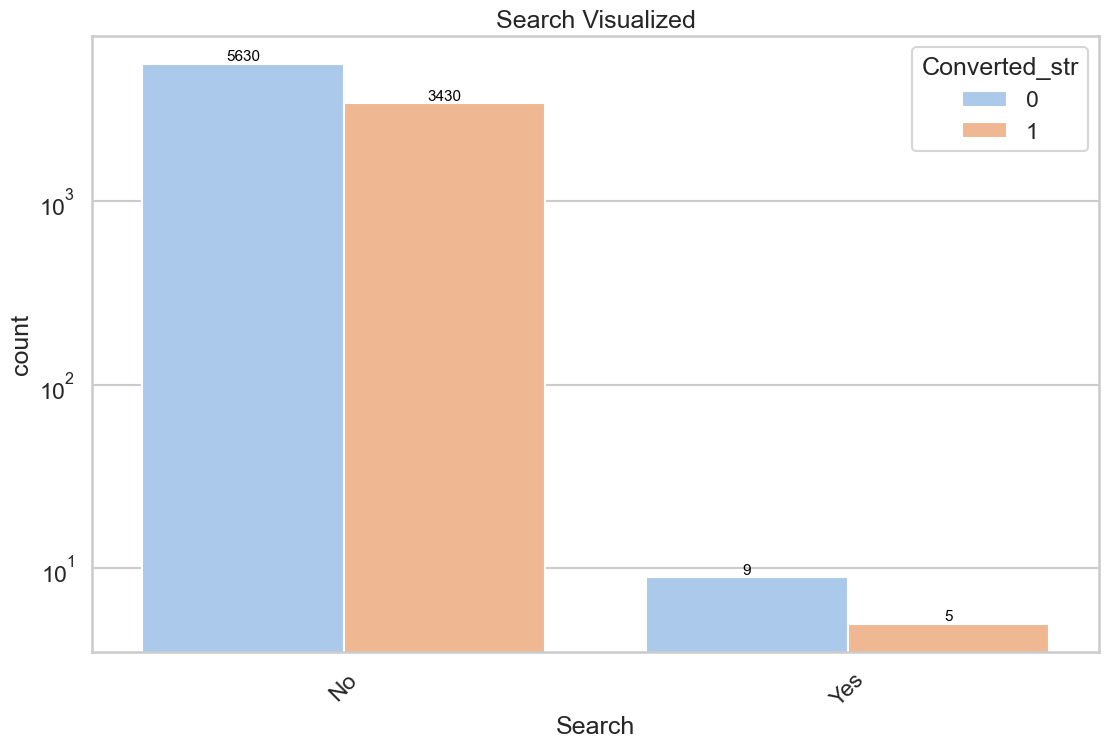

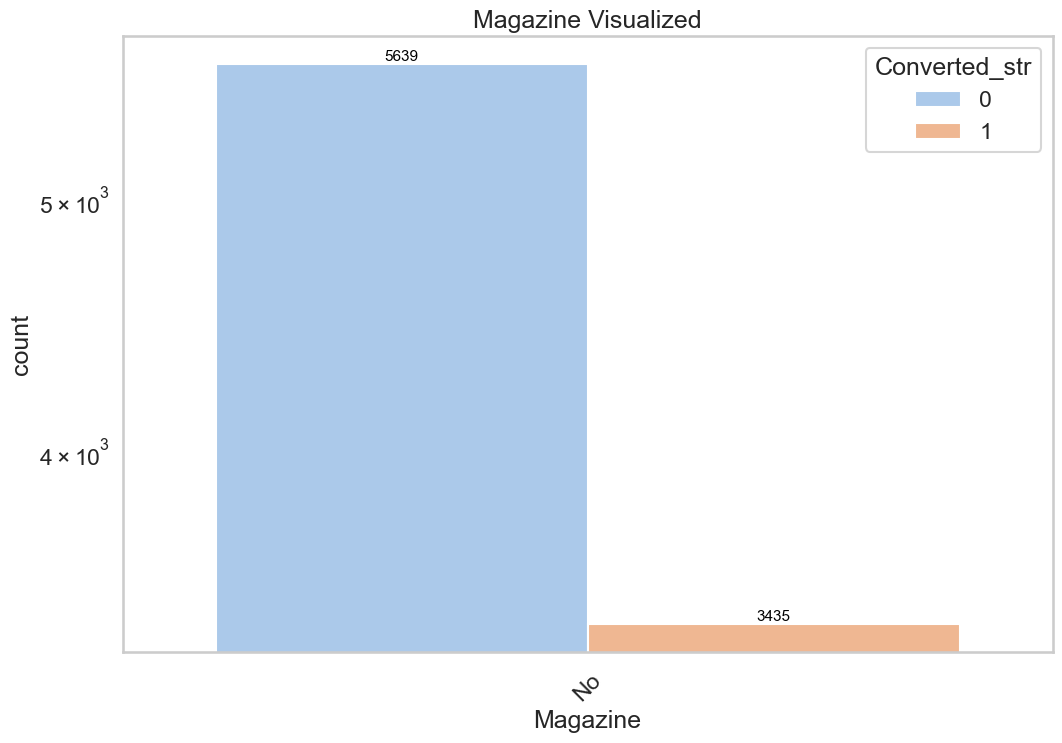

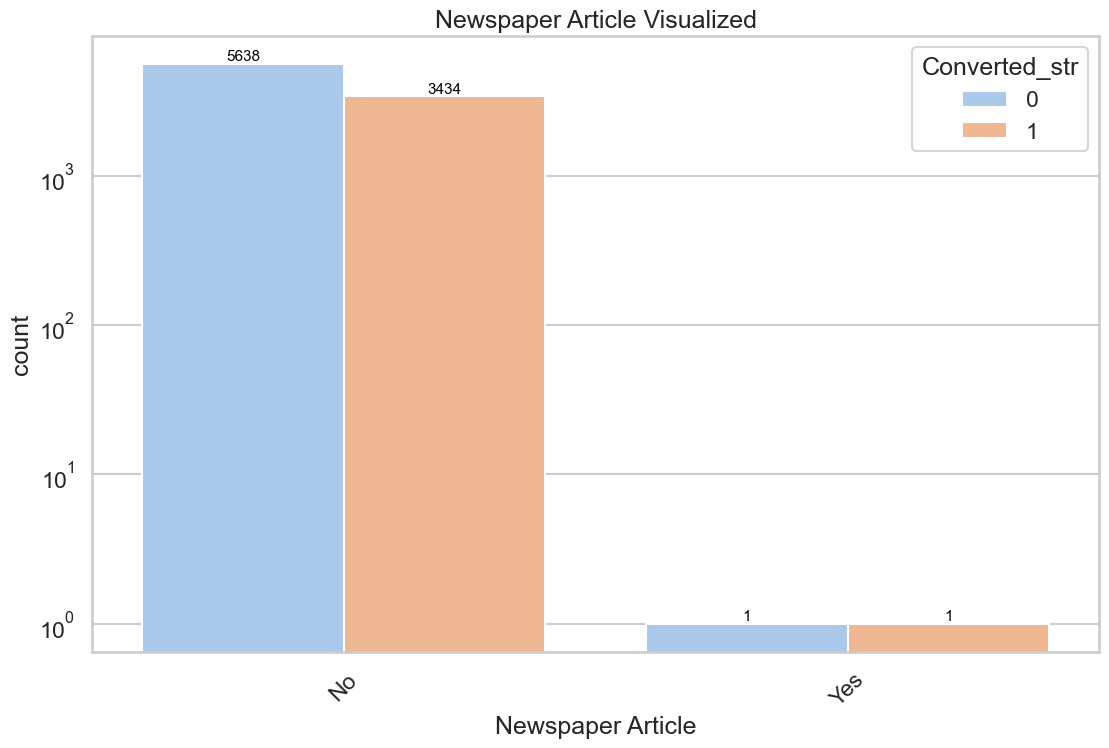

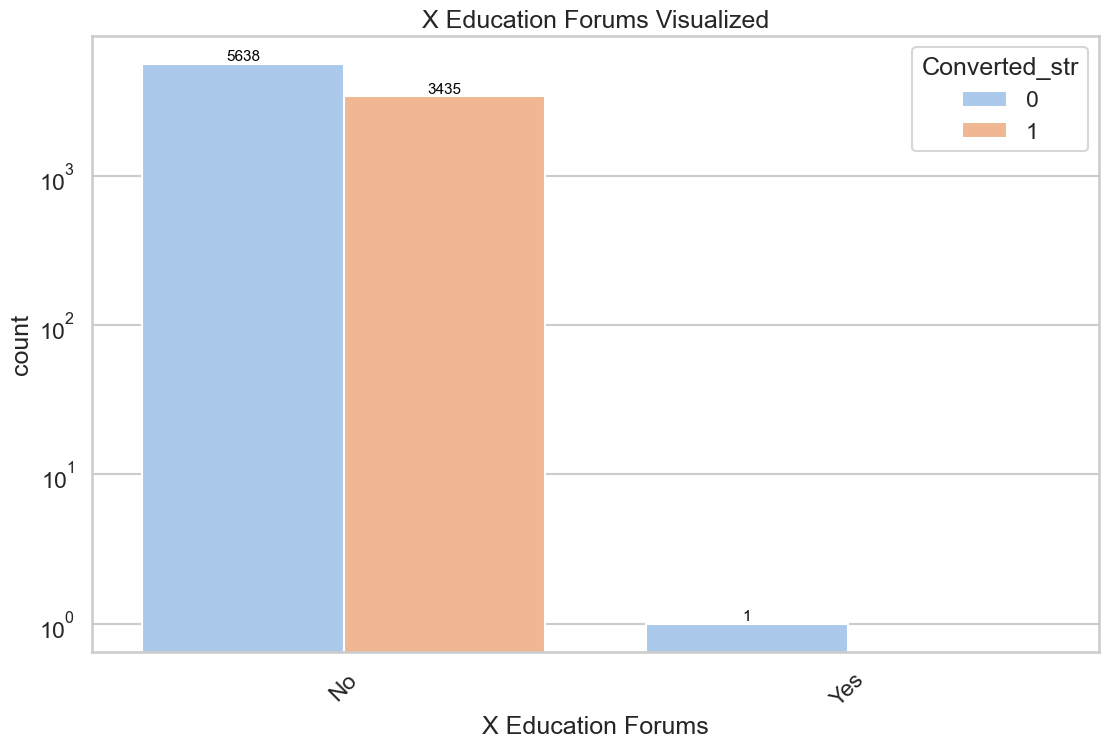

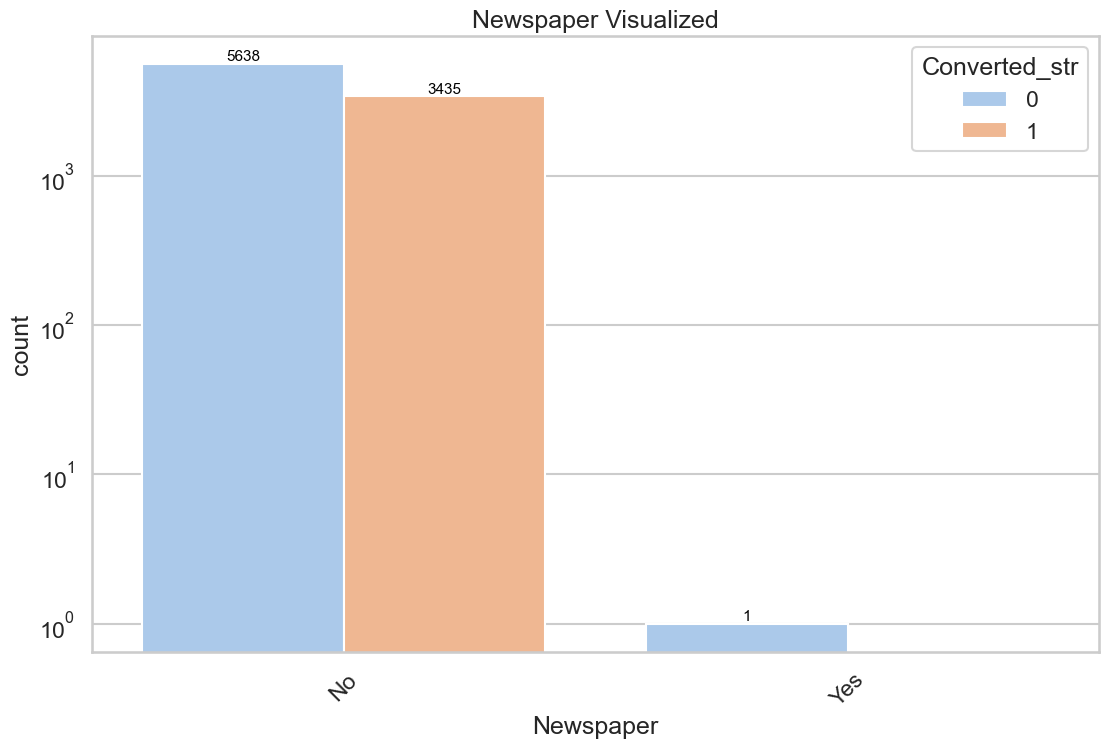

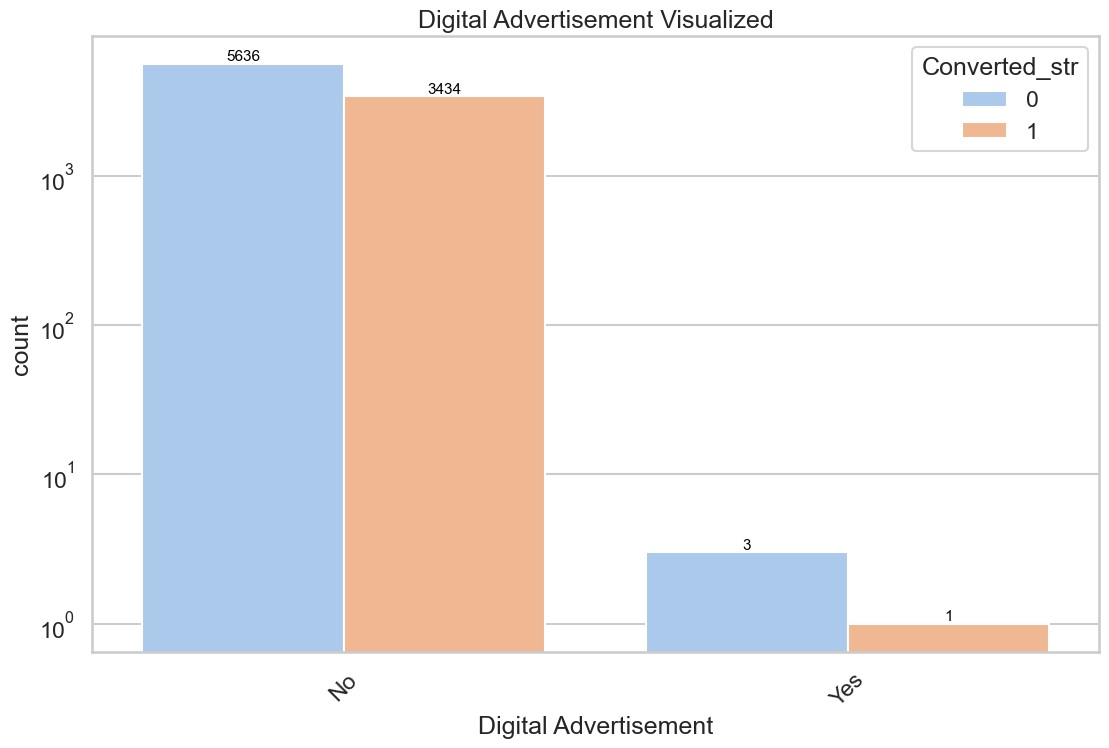

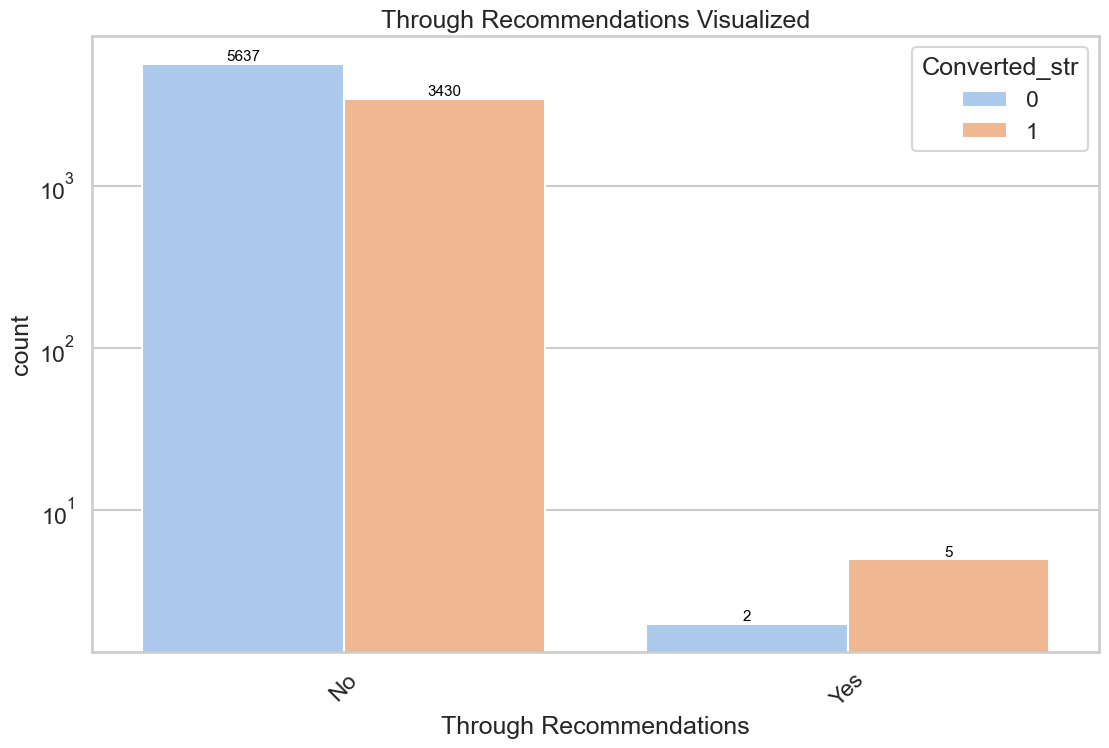

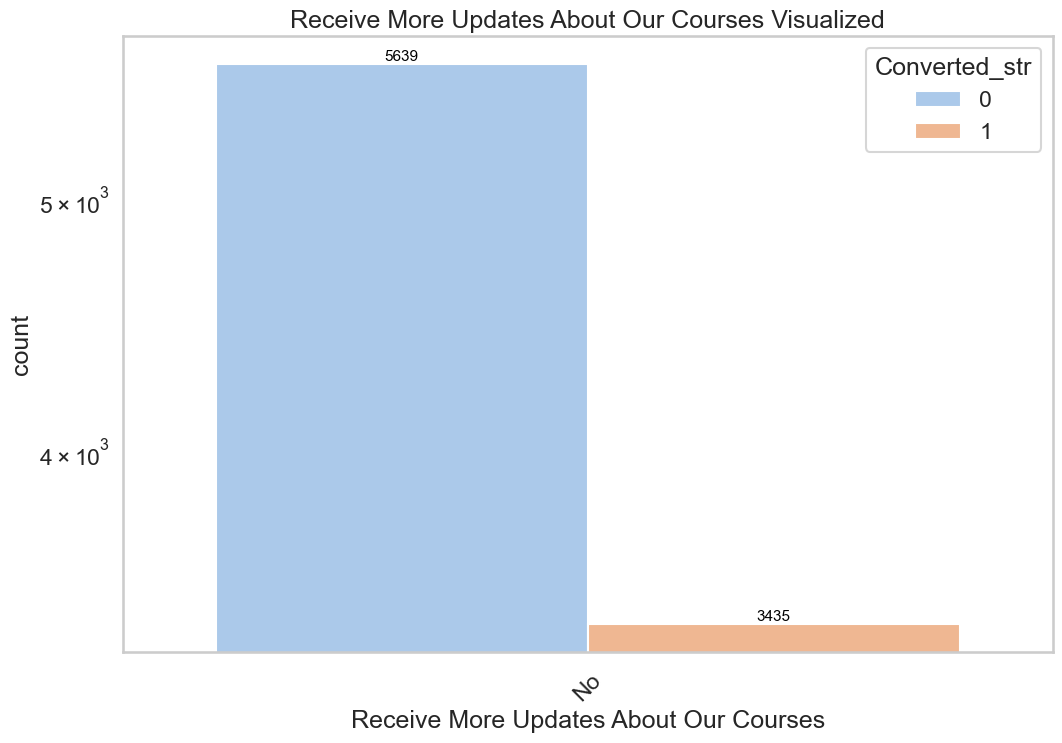

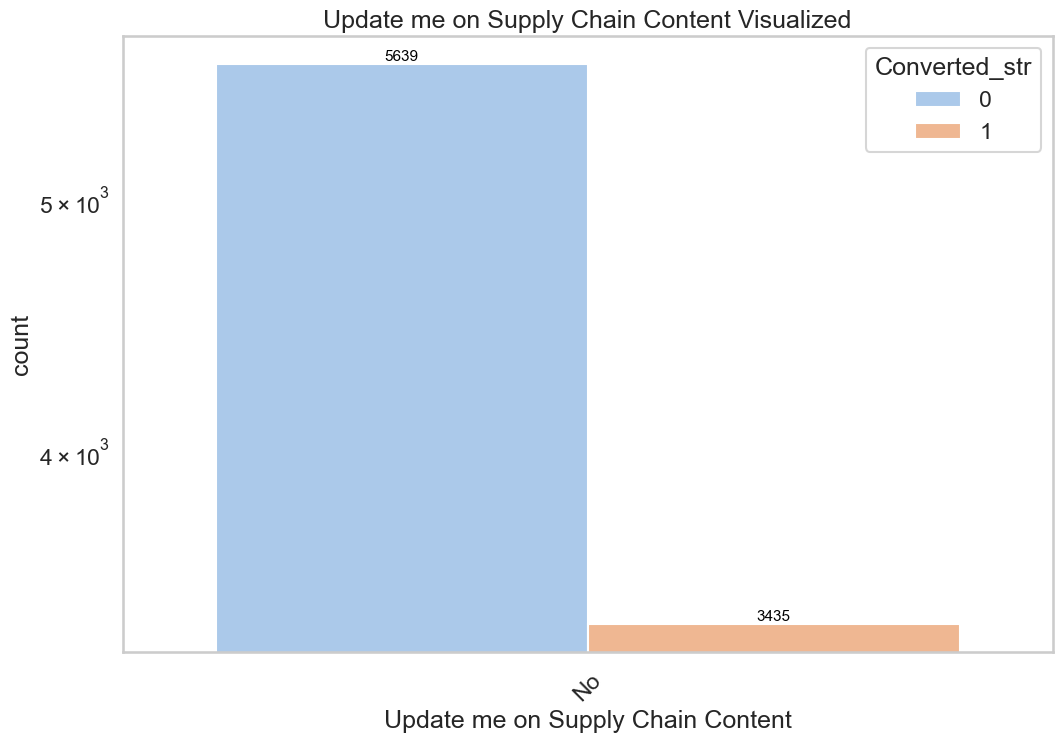

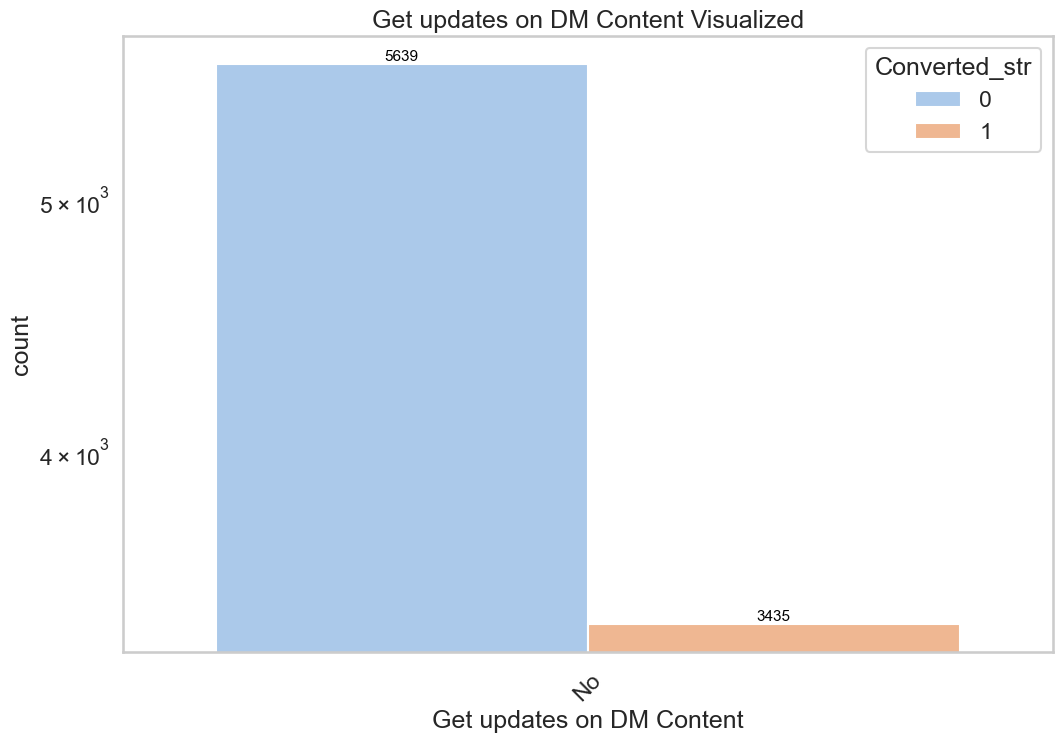

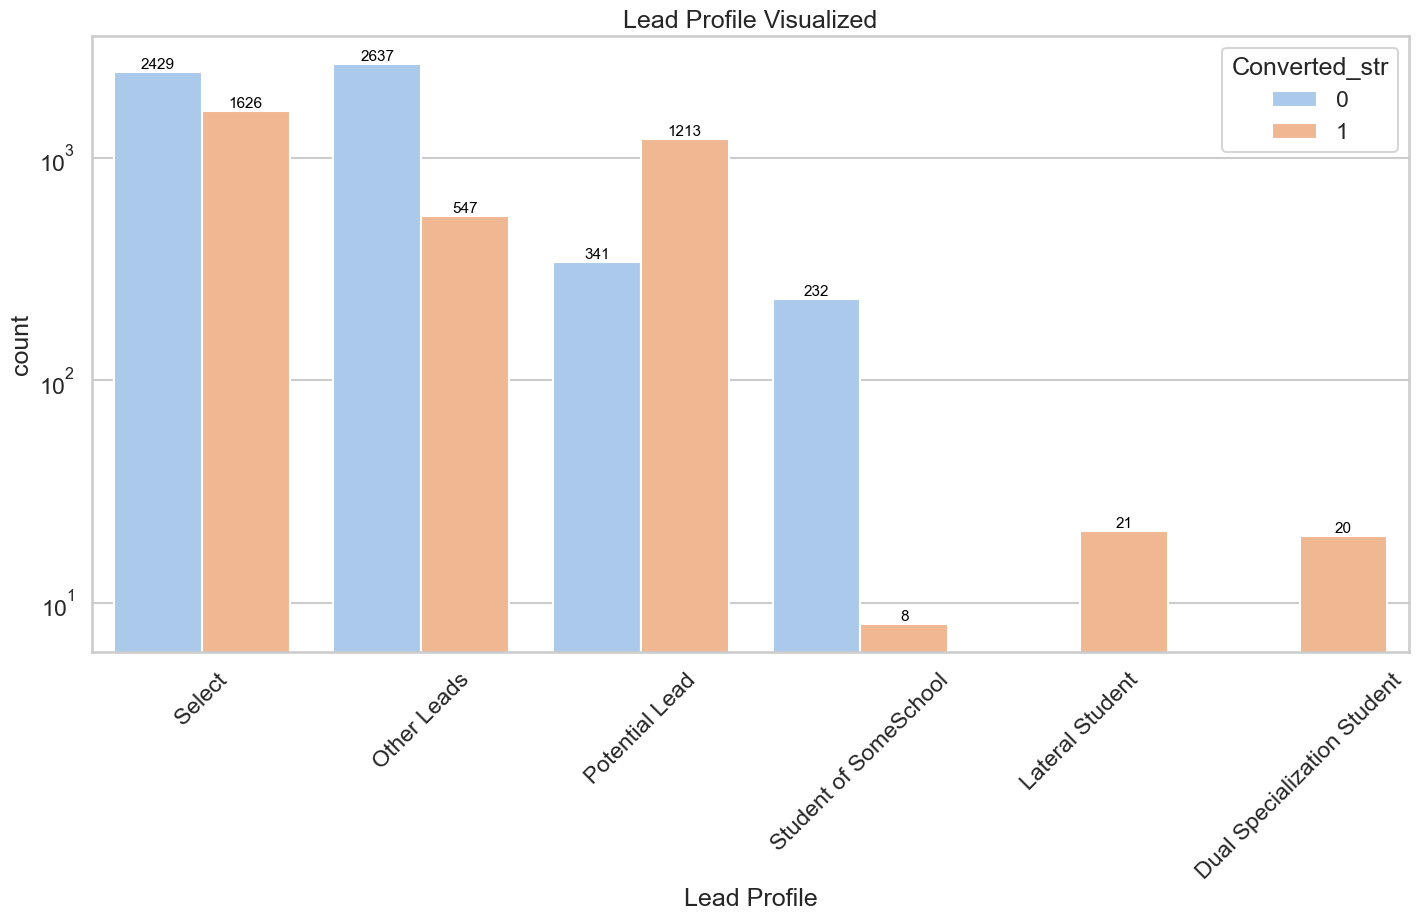

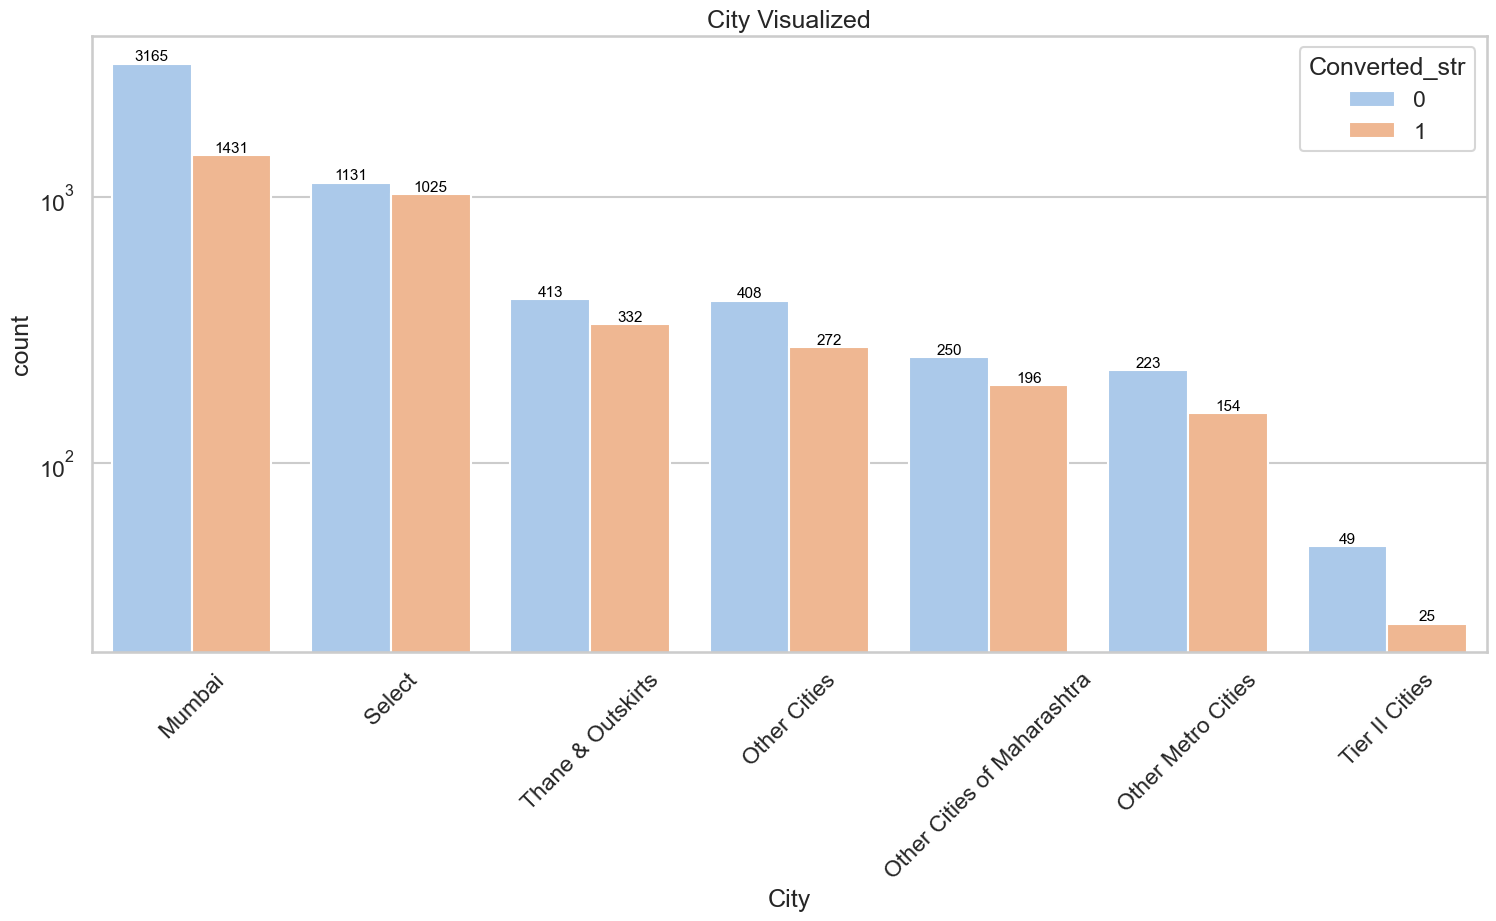

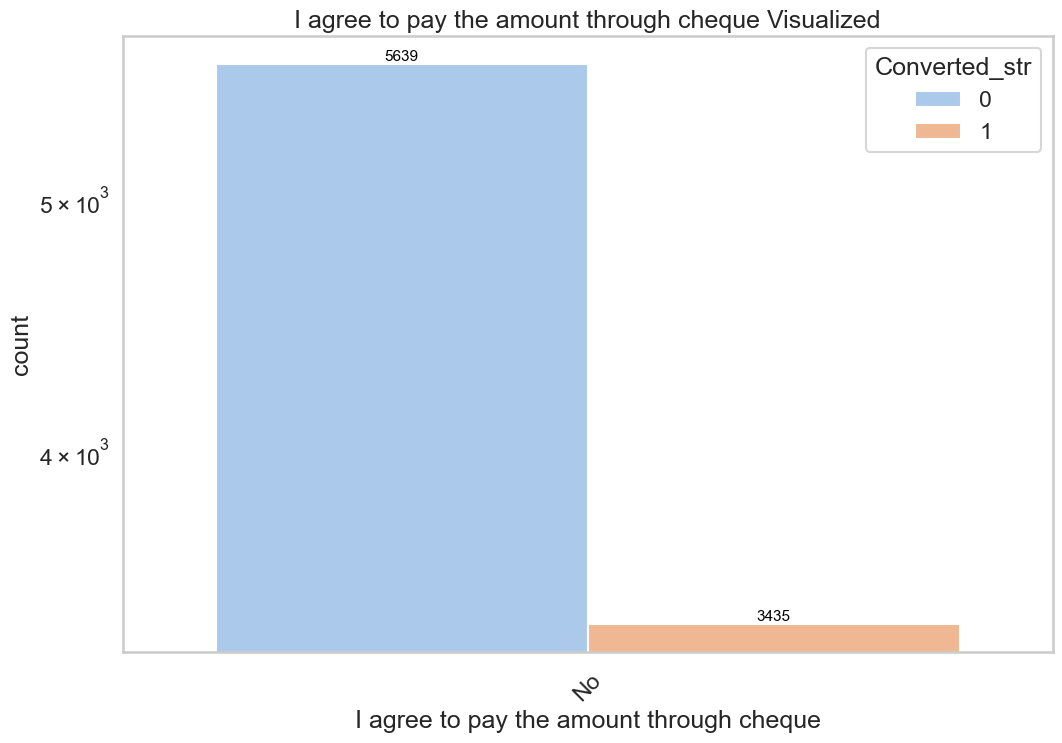

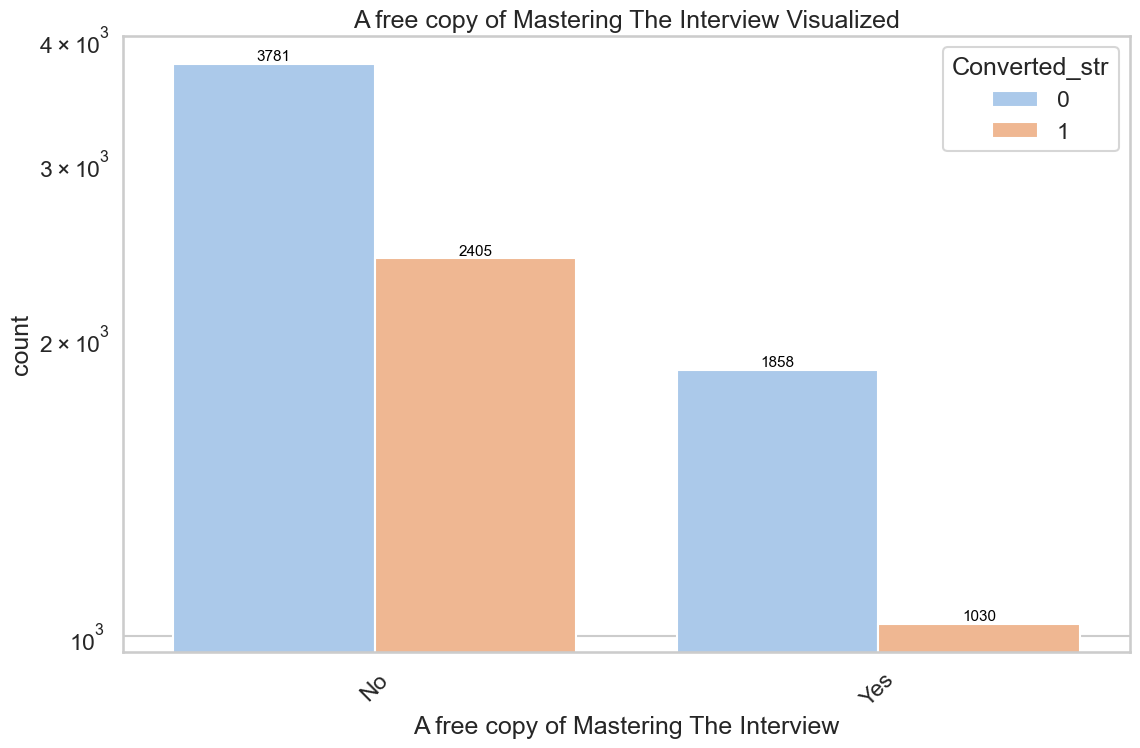

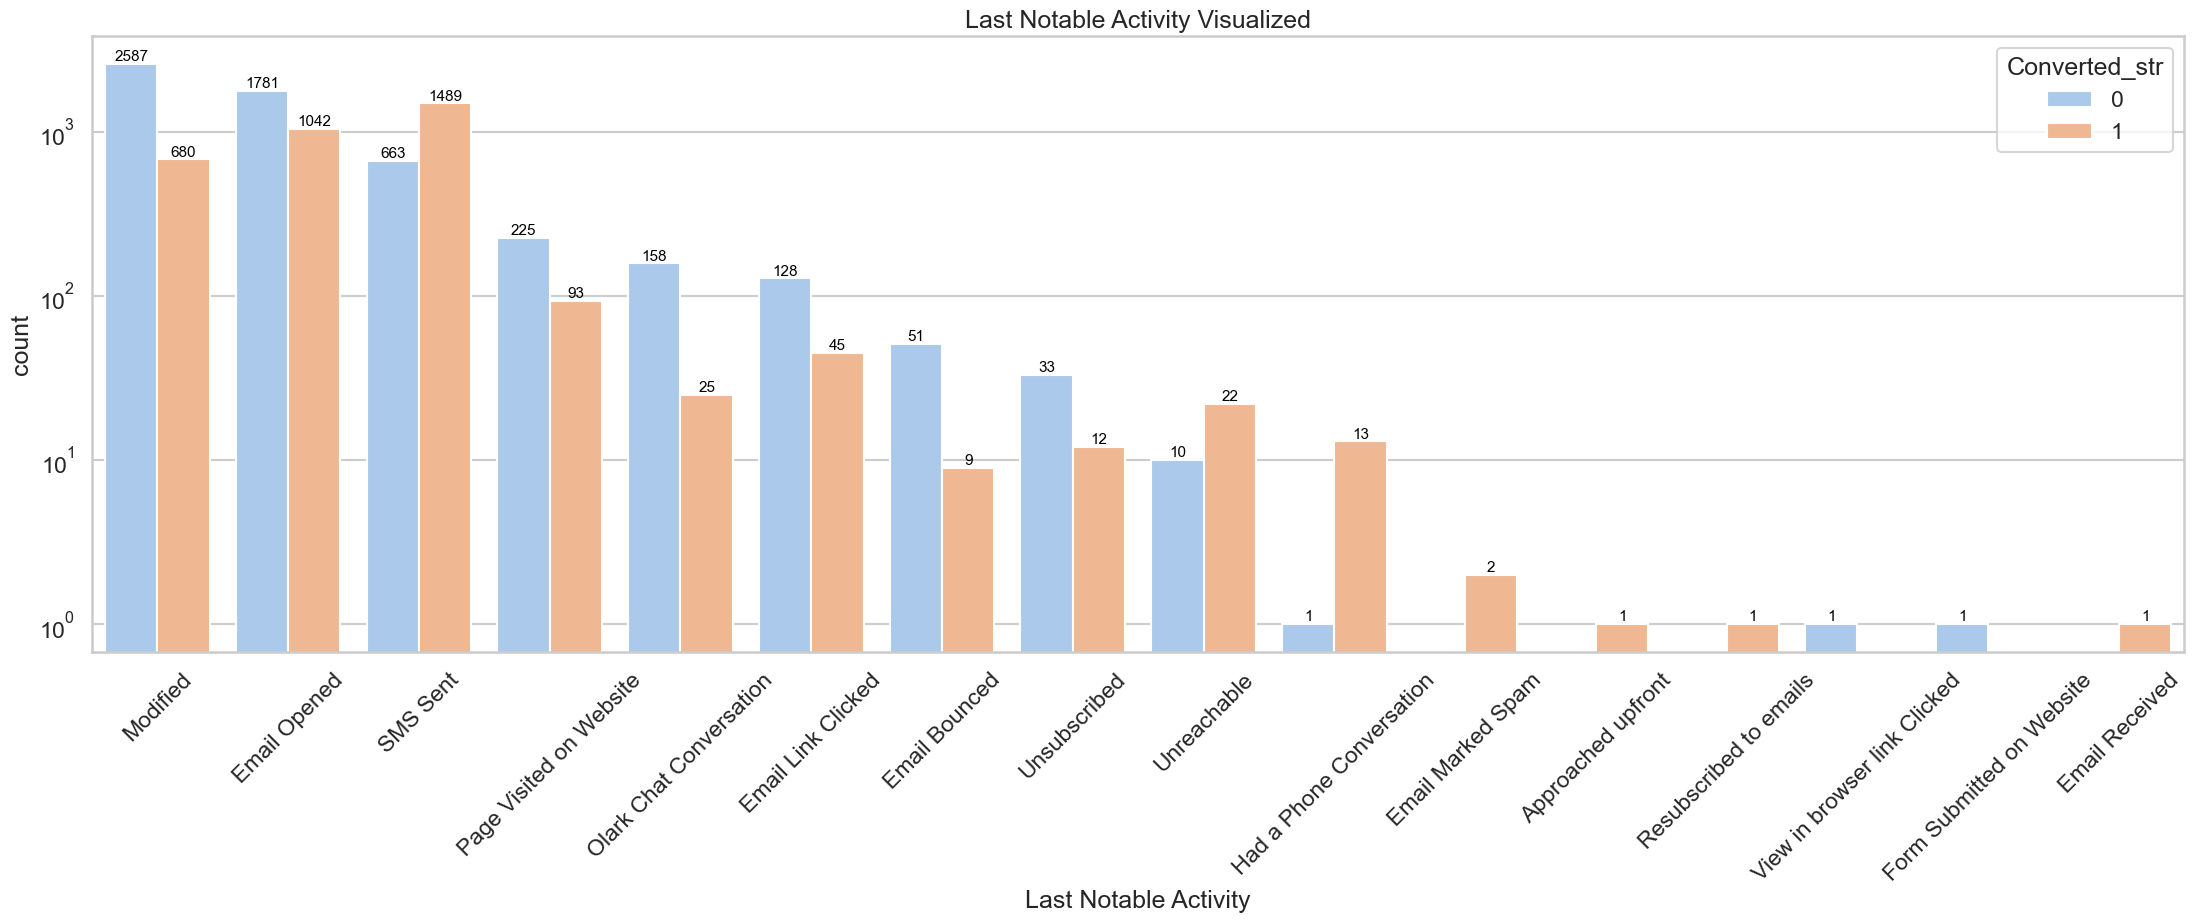

In [10]:
object_columns = lead_data.select_dtypes(include=['object']).columns.tolist()
object_columns.remove("Prospect ID")
# Set a color palette for the pie charts

object_columns
lead_data['Converted_str'] = lead_data['Converted'].astype(str)
for column in object_columns:
    print(column)
    plot_countplot(lead_data, column, hue = 'Converted_str', palette = 'pastel')

lead_data.drop('Converted_str', axis = 1,inplace=True)
lead_data.shape

#### Insights gained from the analysis of object columns
1. Lead Origin:
    API and Landing Page Submission have a 30-35% conversion rate with a substantial lead count.
    Lead Add Form boasts a conversion rate of over 90%, though the lead count is lower.
    Lead Import contributes very few leads.
    To enhance the overall lead conversion rate, efforts should prioritize improving the conversion of leads from API and Landing Page Submission and generating more leads from Lead Add Form.

2. Lead Source:
    Google and Direct traffic are the primary lead generators.
    Reference leads and those through the Welingak website exhibit a high conversion rate.
    Focusing on improving the conversion of Olark chat, organic search, direct traffic, and Google leads while generating more leads from reference and the Welingak website is essential for enhancing the overall lead conversion rate.

3. Last Activity:
    Most leads have their last activity as "Email opened."
    Leads with their last activity as "SMS Sent" achieve an impressive 60% conversion rate.

4. Country:
    Since most values are "India," no significant inference can be drawn from this parameter.

5. Specialization:
    Emphasis should be on specializations with high conversion rates, such as finance and human resource management.

6. What is your current occupation:
    Working professionals opting for the course have a high likelihood of joining it.
    Unemployed leads are the most numerous but maintain a 30-35% conversion rate.

7. Search:
    Most entries are "No," making it challenging to draw meaningful inferences from this parameter.

8. City:
    The majority of leads are from Mumbai, boasting a conversion rate of around 50%.

9. Total Time Spent on Website:
   Leads spending more time on the weblise are more likely to be converted.

10. For most other columns, no noteworthy insights were gleaned from the analysis.

#### 3.3: Cleaning and combining column values of note
We are cleaning and marking some variables of note which were noted during the visualization process.

In [11]:
# Replacing less frequent Last Activities with 'Other_Activity'
lead_data['Last Activity'] = lead_data['Last Activity'].replace(['Had a Phone Conversation', 'View in browser link Clicked', 
                                                       'Visited Booth in Tradeshow', 'Approached upfront',
                                                       'Resubscribed to emails','Email Received', 'Email Marked Spam'], 'Other_Activity')

# Placing 'Others' category for some less frequent Lead Sources
lead_data['Lead Source'] = lead_data['Lead Source'].replace(['Click2call', 'Live Chat', 'NC_EDM', 'Pay per Click Ads', 'Press_Release',
  'Social Media', 'WeLearn', 'bing', 'blog', 'testone', 'welearnblog_Home', 'youtubechannel'], 'Others')

# Replace 'google' with 'Google' for consistency
lead_data['Lead Source'] = lead_data['Lead Source'].replace(['google'], 'Google')
# Removing columns as they are irrelevant to analysis
lead_data.drop(['Prospect ID', 'Lead Number'], axis = 1,inplace=True)

#### Correlation Matrices

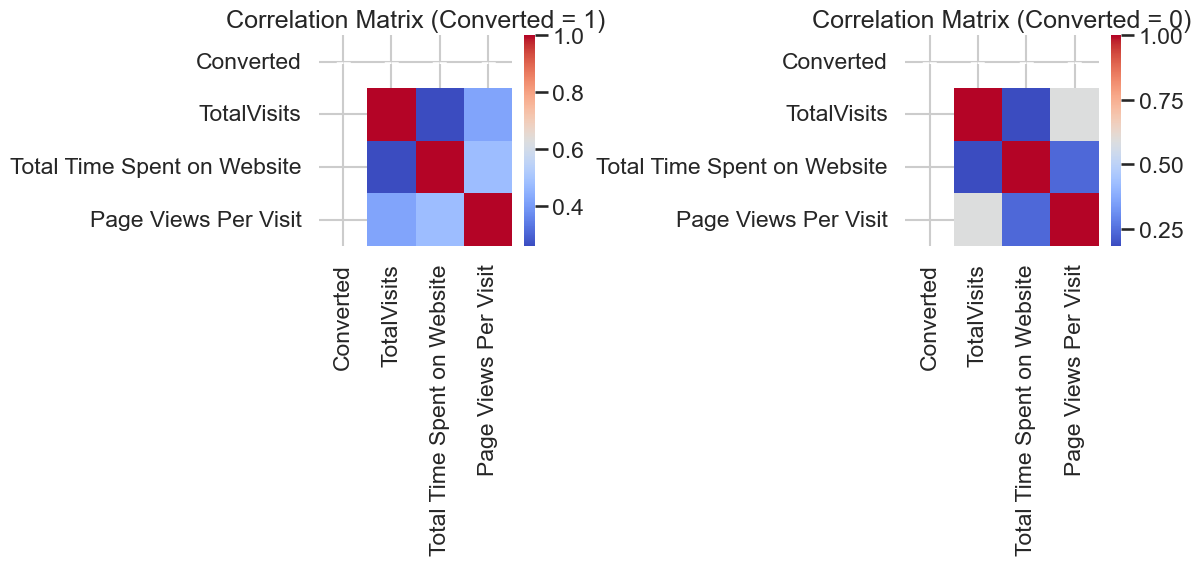

In [12]:
# Excluding non-numeric columns (example: 'unique_id_column')
numeric_columns = lead_data.select_dtypes(include=[np.number]).columns.tolist()
lead_data_numeric = lead_data[numeric_columns]

# Splitting the dataset into two based on 'Converted' values
lead_data_converted = lead_data_numeric[lead_data_numeric['Converted'] == 1]
lead_data_not_converted = lead_data_numeric[lead_data_numeric['Converted'] == 0]

# Calculating correlation matrices
corr_matrix_converted = lead_data_converted.corr()
corr_matrix_not_converted = lead_data_not_converted.corr()

# Plotting the correlation matrices
plt.figure(figsize=(12, 6))

# Correlation matrix for 'Converted' = 1
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.heatmap(corr_matrix_converted, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Converted = 1)')

# Correlation matrix for 'Converted' = 0
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.heatmap(corr_matrix_not_converted, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Converted = 0)')

plt.tight_layout()
plt.show()

## Step 4: Feature Engineering and Data Preparation
This step involves:
* Encoding categorical variables efficiently using pd.get_dummies().
* Splitting the data into training and test sets.
* Scaling the numeric features appropriately.

In [13]:
# Feature Engineering - Creating new features based on EDA insights
# For demonstration, let's create a new feature combining 'TotalVisits' and 'Page Views Per Visit'
lead_data['Visits_PageViews'] = lead_data['TotalVisits'] * lead_data['Page Views Per Visit']
# Encode categorical variables using pd.get_dummies()
categorical_cols = lead_data.select_dtypes(include=['object', 'category']).columns
lead_data_encoded = pd.get_dummies(lead_data, columns=categorical_cols, drop_first=True)

# Split the data into training and test sets
X = lead_data_encoded.drop('Converted', axis=1)  # Assuming 'Converted' is the target variable
y = lead_data_encoded['Converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the numeric features
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Quick check
print(X_train.head())
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

      TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
1943    -0.304688                     1.704380             -0.169010   
456     -0.304688                    -0.789845             -0.169010   
6547     0.326520                    -0.176811              1.206110   
8836     0.116117                     2.117949              0.747736   
6529     0.326520                     0.315446              1.206110   

      Visits_PageViews  Lead Origin_Landing Page Submission  \
1943         -0.212195                                 True   
456          -0.212195                                False   
6547          0.262177                                 True   
8836          0.058875                                False   
6529          0.262177                                 True   

      Lead Origin_Lead Add Form  Lead Origin_Lead Import  \
1943                      False                    False   
456                       False                    False   
6547    

## Step 5: Model Building

For model building, we'll use logistic regression, given its suitability for binary classification problems like lead scoring. To address previous inefficiencies, we'll incorporate the following improvements:

* Use LogisticRegression from sklearn for model building.
* Apply feature selection techniques more systematically, leveraging RFE (Recursive Feature Elimination) for an initial set of features and then refining as necessary based on model performance metrics.

Num Features: 15
Selected Features: Index(['Total Time Spent on Website', 'Lead Origin_Lead Add Form',
       'Lead Source_Olark Chat', 'Lead Source_Welingak Website',
       'Do Not Email_Yes', 'Last Activity_Other_Activity',
       'Last Activity_SMS Sent', 'Country_Saudi Arabia',
       'Specialization_Others', 'What is your current occupation_Housewife',
       'What is your current occupation_Working Professional',
       'Lead Profile_Lateral Student', 'Lead Profile_Potential Lead',
       'Lead Profile_Student of SomeSchool',
       'Last Notable Activity_Unreachable'],
      dtype='object')
Feature Ranking: [ 58   1  64  92  16   1  57  26  70   1  78 110   7  81   1   1  47  29
  41  12  82  32   1  67   1  43  66  77  22  97  88  85  62 100  23  37
  93  69  25 115   6  86  83 108 112  38   3  21  60  33 114   1  76  28
 103 113  80  95  40  24  99  94  68  20  98  45  73  91  87   8 109 107
  89  59  50  90   1  49  19  42  79 105 102  17  46 106  51  34  27  75
  39  54  65

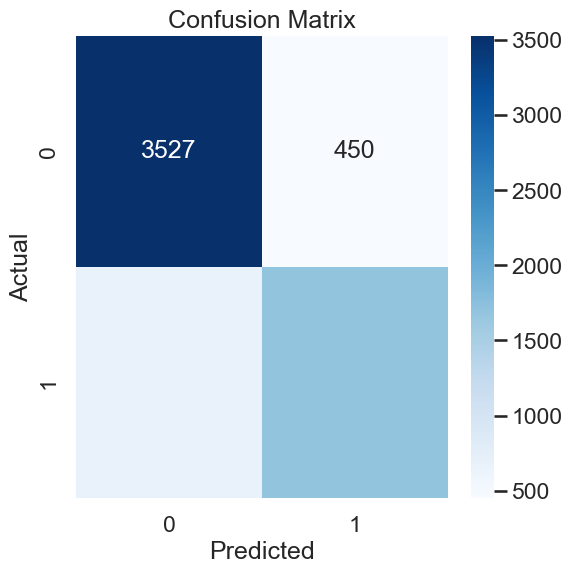

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      3977
           1       0.79      0.72      0.75      2374

    accuracy                           0.82      6351
   macro avg       0.81      0.80      0.81      6351
weighted avg       0.82      0.82      0.82      6351



In [14]:
# Initialize the logistic regression model
logreg = LogisticRegression()

# Apply RFE for feature selection, aiming for an initial set of 15 features
rfe = RFE(estimator=logreg, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

# Summarize the selection of the attributes
print("Num Features: %s" % (rfe.n_features_))
print("Selected Features: %s" % (X_train.columns[rfe.support_]))
print("Feature Ranking: %s" % (rfe.ranking_))

# Fitting logistic regression on the training data
X_train_rfe = X_train[X_train.columns[rfe.support_]]
logreg.fit(X_train_rfe, y_train)

# Predicting on the training set
y_train_pred = logreg.predict(X_train_rfe)

# Model Evaluation
print("Training Accuracy :", accuracy_score(y_train, y_train_pred))
print("Training ROC AUC :", roc_auc_score(y_train, logreg.predict_proba(X_train_rfe)[:,1]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print(classification_report(y_train, y_train_pred))


The model demonstrates strong predictive power with a ROC AUC of 0.896, indicating excellent capability in distinguishing between converted and not-converted leads. Additionally, a balanced accuracy of 82.27% alongside good precision and recall scores for both classes signifies its effectiveness in accurately classifying leads, making it a reliable tool for prioritizing potential customers.

### 5.2: Feature Importance
Here, we chart out the importance of features using model coefficients, and determine the top 10 most important features determined by the model.

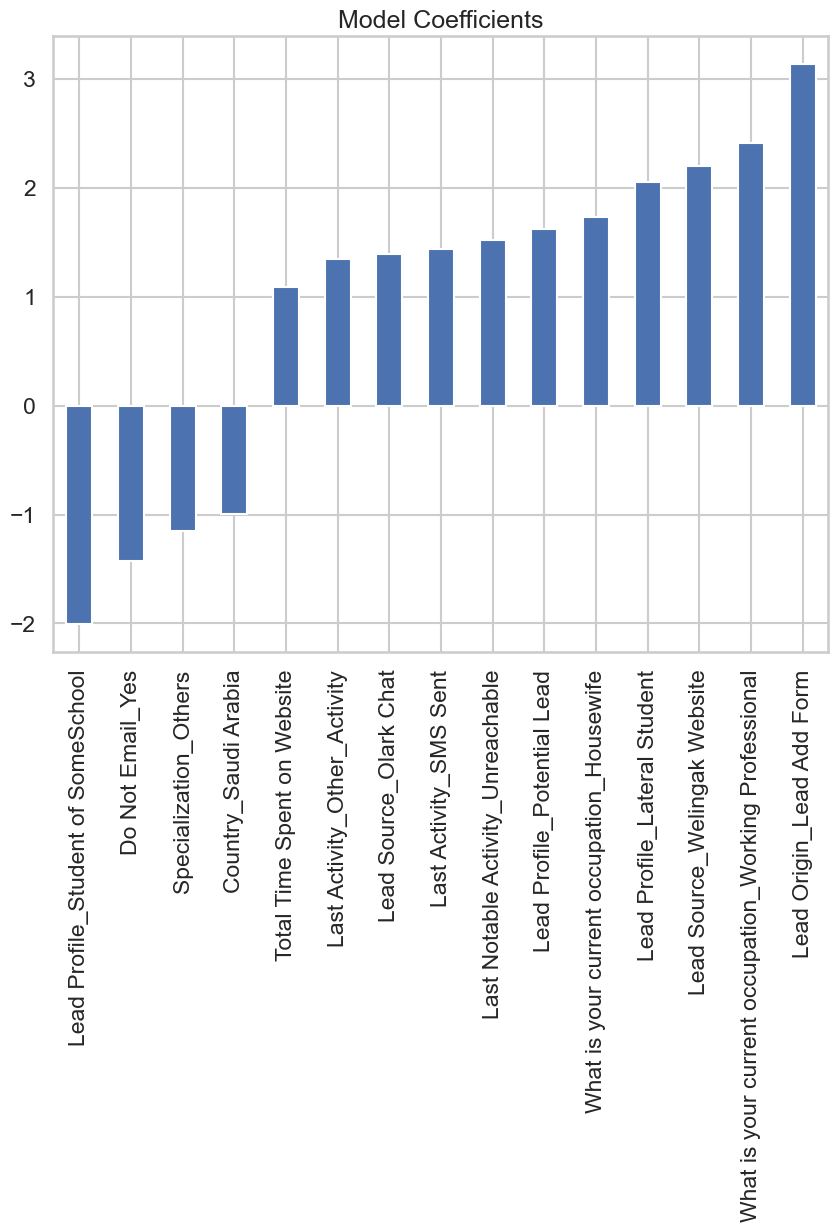

In [15]:
# Feature Importance
plt.figure(figsize=(10, 8))
coef = pd.Series(logreg.coef_[0], index = X_train_rfe.columns).sort_values()
coef.plot(kind='bar', title='Model Coefficients')
plt.show()

Top 10 Coefficients by Absolute Value:

    Lead Origin_Lead Add Form (Highly positive)
    What is your current occupation_Working Professional (Highly positive)
    Lead Source_Welingak Website (Highly positive)
    Last Notable Activity_Unreachable (Highly positive)
    What is your current occupation_Housewife (Highly positive)
    Lead Profile_Potential Lead (Positive)
    Lead Profile_Lateral Student (Positive)
    Lead Profile_Student of SomeSchool (Highly negative)
    Last Activity_SMS Sent (Positive)
    Total Time Spent on Website (Positive)

Insights for the Case Study:

* High-Value Actions and Sources: The top positive coefficients like Lead Origin_Lead Add Form, Lead Source_Welingak Website, and actions such as Last Notable Activity_Unreachable suggest that leads from specific sources or those who have been difficult to contact are very likely to convert if engaged correctly.
* Occupational Impact: Working professionals are highly likely to convert, indicating the effectiveness of targeting this demographic. Conversely, the negative coefficient for Lead Profile_Student of SomeSchool suggests that this group is less likely to convert, which could indicate a need for different engagement strategies or a reevaluation of the lead scoring for this segment.
* Engagement and Content: Total Time Spent on Website and Last Activity_SMS Sent having positive coefficients show that engaged leads and those who respond well to SMS communication are more likely to convert. This implies that enhancing website content and maintaining SMS communication could be beneficial.
* Demographic Considerations: The presence of Country_Saudi Arabia suggests geographic location may play a role in lead conversion, possibly due to regional preferences or market fit, which might warrant further investigation.

These insights can guide X Education in optimizing their lead engagement strategies, resource allocation, and overall marketing efforts to improve conversion rates.

### 5.3 Visualizing Model Performance
In addition to the confusion matrix and model coefficients, it's also insightful to plot the ROC curve to evaluate the model's performance in distinguishing between the converted and not-converted leads.

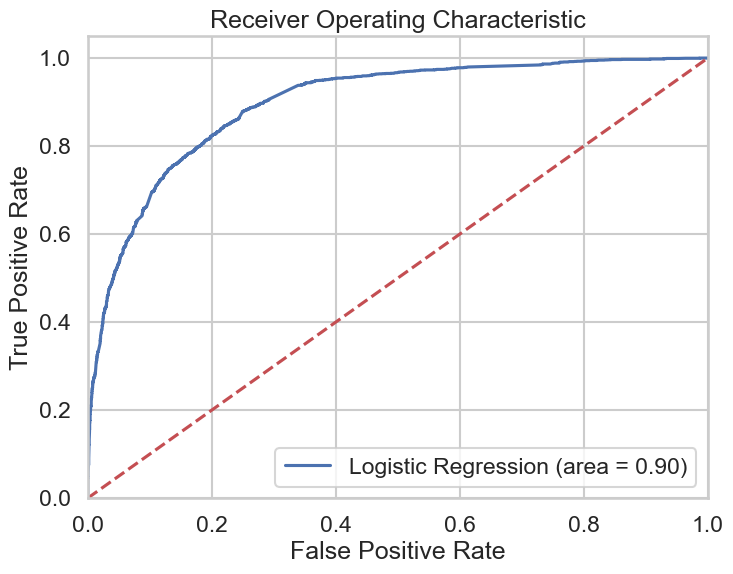

In [16]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_train, logreg.predict_proba(X_train_rfe)[:,1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_train, logreg.predict_proba(X_train_rfe)[:,1]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


The ROC curve indicates that the logistic regression model has a high discriminative ability to distinguish between positive and negative classes, with an AUC of 0.90, which is close to 1. This high AUC value suggests that the model has a good measure of separability, meaning it's capable of classifying the leads with a high degree of accuracy.

## Step 6: Model Optimization and Evaluation

After building the initial model and evaluating its performance on the training set, the next step is to optimize the model and evaluate it on the test set. Optimization may involve adjusting the model's threshold for classification based on precision-recall tradeoffs and evaluating the model's performance using a variety of metrics.

### 6.1: Optimizing the Classification Threshold

The default threshold for classifying probabilities into classes (converted or not converted) is 0.5. However, depending on the business objectives, adjusting this threshold can improve either precision (how many selected leads are actually converted) or recall (how many of the converted leads were actually selected).

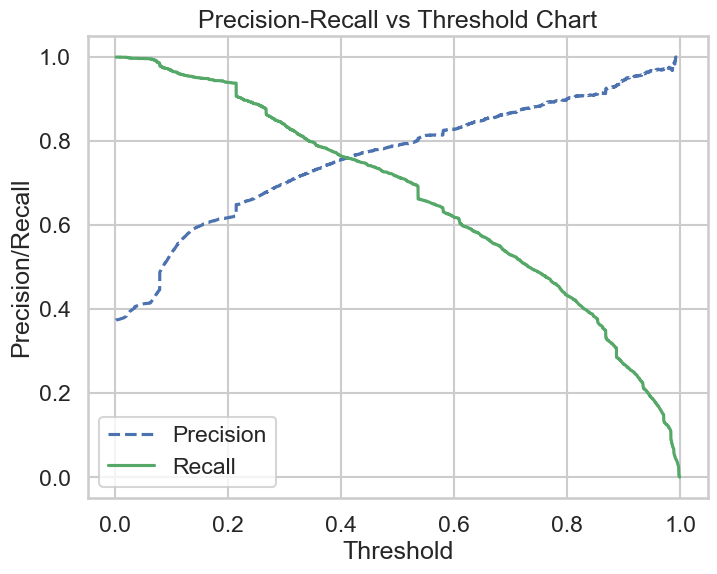

In [17]:
# Predict probabilities
y_train_pred_probs = logreg.predict_proba(X_train_rfe)[:,1]

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_train, y_train_pred_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.title("Precision-Recall vs Threshold Chart")
plt.legend()
plt.show()


Based on the business objective of maximizing lead conversion without excessively increasing the sales team's workload, a balance between precision and recall should be found. This often means selecting a threshold that maintains a high recall while keeping precision reasonable.
From the curve, we can infer that the best threshold providing a good balance between precision and recall is 0.4

### 6.2: Applying the Optimized Model to the Test Set

Once the threshold is optimized, we will apply this to classify leads in the test set and evaluate the model's performance.

Test Accuracy : 0.8200514138817481
Test ROC AUC : 0.8906567039926686


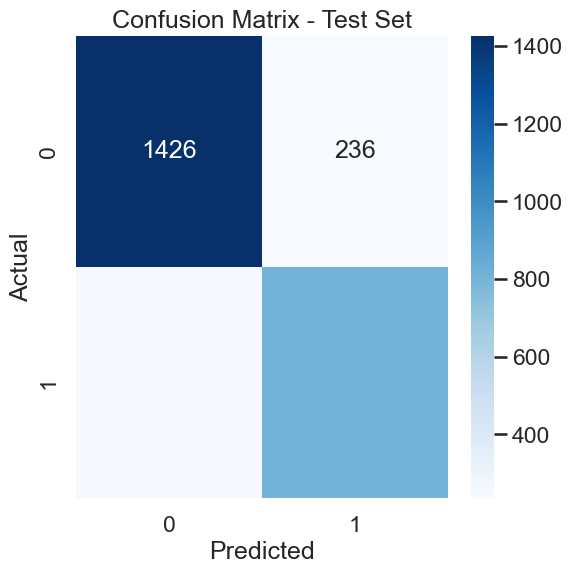

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1662
           1       0.77      0.76      0.77      1061

    accuracy                           0.82      2723
   macro avg       0.81      0.81      0.81      2723
weighted avg       0.82      0.82      0.82      2723



In [18]:
# Using an optimized threshold (e.g., 0.4 based on the Precision-Recall curve)
opt_threshold = 0.4

# Prepare test data (using the same features as the training set)
X_test_rfe = X_test[X_train_rfe.columns]

# Predict probabilities on the test set
y_test_pred_probs = logreg.predict_proba(X_test_rfe)[:,1]

# Apply optimized threshold to classify leads
y_test_pred_optimized = (y_test_pred_probs >= opt_threshold).astype(int)

# Evaluate performance on the test set
print("Test Accuracy :", accuracy_score(y_test, y_test_pred_optimized))
print("Test ROC AUC :", roc_auc_score(y_test, y_test_pred_probs))

# Confusion Matrix on the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred_optimized)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report on the test set
print(classification_report(y_test, y_test_pred_optimized))


### 6.3 Visualizing model performance between the ideal threshold and the threshold requested by the team
As per the project requirements, the threshold for 'hot leads' is to be set at 0.8 (80% chance of conversion or more).
We now visualize the differences between the requested threshold and the optimum threshold as determined by our tuning.

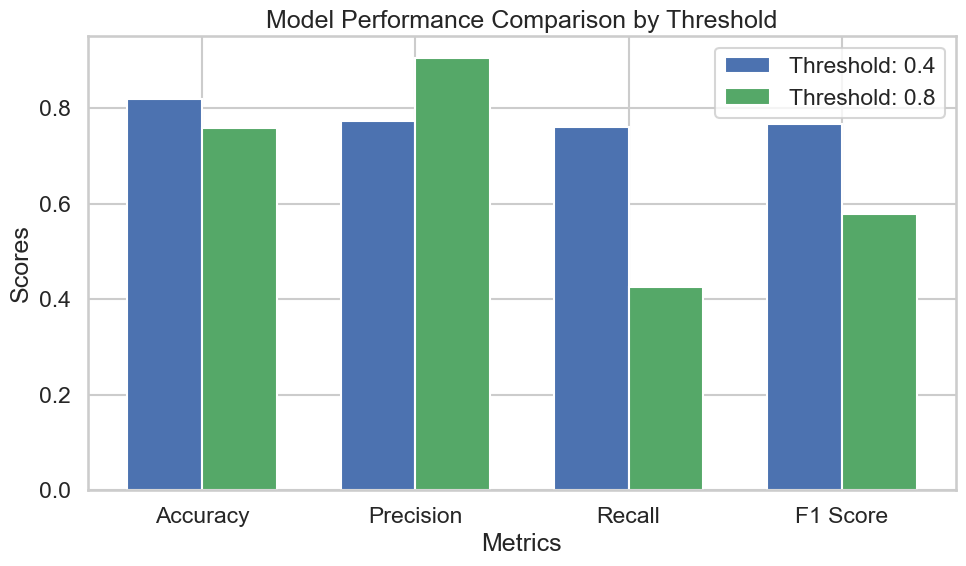

In [19]:
def visualize_threshold_differences(y_true, y_probs, threshold1, threshold2):
    # Convert probabilities to binary predictions based on thresholds
    y_pred_thresh1 = (y_probs >= threshold1).astype(int)
    y_pred_thresh2 = (y_probs >= threshold2).astype(int)
    
    # Calculate metrics for both thresholds
    accuracy1 = accuracy_score(y_true, y_pred_thresh1)
    precision1 = precision_score(y_true, y_pred_thresh1)
    recall1 = recall_score(y_true, y_pred_thresh1)
    f1_1 = f1_score(y_true, y_pred_thresh1)
    
    accuracy2 = accuracy_score(y_true, y_pred_thresh2)
    precision2 = precision_score(y_true, y_pred_thresh2)
    recall2 = recall_score(y_true, y_pred_thresh2)
    f1_2 = f1_score(y_true, y_pred_thresh2)
    
    # Plotting
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values1 = [accuracy1, precision1, recall1, f1_1]
    values2 = [accuracy2, precision2, recall2, f1_2]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(metrics))
    
    bars1 = plt.bar(index, values1, bar_width, color='b', label=f'Threshold: {threshold1}')
    bars2 = plt.bar(index + bar_width, values2, bar_width, color='g', label=f'Threshold: {threshold2}')
    
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Model Performance Comparison by Threshold')
    plt.xticks(index + bar_width / 2, metrics)
    plt.legend()
    plt.tight_layout()
    
    plt.show()

visualize_threshold_differences(y_test, y_test_pred_probs, 0.4, 0.8)


The chart shows that at a threshold of 0.4, the model achieves a balance of accuracy, precision, recall, and F1 score, indicating a well-rounded performance. 

However, when the threshold is raised to 0.8, precision increases significantly at the cost of recall, suggesting that while we are more confident about the leads we classify as 'hot', we also miss out on a higher number of potential leads. 

This trade-off is important for the business to consider depending on their capacity to pursue leads and the importance of not missing potential opportunities.

## Step 7: Getting 'hot leads'
Now that we have trained and evaluated a model, we provide the below function to the team which performs all the steps required to evaluate their datasets now and in the future.
The function : 
* Takes the csv file containing data on all potential leads as inputs 
* Cleans the dataset as per our previous characteristics
* Creates dummy variables and standardizes the dataset
* Runs the logistic regression model using the columns determined via RFE
* Filters out rows which are having an 80% or higher chance of conversion
* Provides the 'hot leads' as an output


In [20]:
def filter_high_probability_leads(csv_file_path):

    df = pd.read_csv(csv_file_path)
    df.drop(columns = ['Tags', 'Lead Quality', 'Asymmetrique Activity Index','Asymmetrique Profile Index', 'Asymmetrique Activity Score','Asymmetrique Profile Score'],inplace=True)

    # Fill missing values
    df['Specialization'].fillna('Others', inplace=True)
    df['How did you hear about X Education'].fillna('Others', inplace=True)
    df['What is your current occupation'].fillna('Unemployed', inplace=True)
    df['Country'].fillna('India', inplace=True)
    df['City'].fillna('Mumbai', inplace=True)
    df['Lead Profile'].fillna('Other Leads', inplace=True)
    df.drop('What matters most to you in choosing a course',axis=1,inplace=True)
    df.dropna(inplace=True)

    # IMPORTANT - When using an external or potential leads dataset, the column 'Converted' will not exist
    # Hence the following line of code is used to mimic real-world scenarios
    if 'Converted' in df.columns:
        df.drop('Converted', axis=1,inplace=True)

    # Replacing less frequent Last Activities with 'Other_Activity'
    df['Last Activity'] = df['Last Activity'].replace(['Had a Phone Conversation', 'View in browser link Clicked', 
                                                       'Visited Booth in Tradeshow', 'Approached upfront',
                                                       'Resubscribed to emails','Email Received', 'Email Marked Spam'], 'Other_Activity')
    
    # Placing 'Others' category for some less frequent Lead Sources
    df['Lead Source'] = df['Lead Source'].replace(['Click2call', 'Live Chat', 'NC_EDM', 'Pay per Click Ads', 'Press_Release',
    'Social Media', 'WeLearn', 'bing', 'blog', 'testone', 'welearnblog_Home', 'youtubechannel'], 'Others')
    
    # Replace 'google' with 'Google' for consistency
    df['Lead Source'] = df['Lead Source'].replace(['google'], 'Google')
    df['Visits_PageViews'] = df['TotalVisits'] * df['Page Views Per Visit']
    
    # Encode categorical variables using pd.get_dummies()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    numeric_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    
    df_encoded[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    # Ensure only the columns used by the model are in X
    X = df_encoded[logreg.feature_names_in_]
    
    # Predict probabilities
    probabilities = logreg.predict_proba(X)[:, 1]  # The second column is for the positive class
    
    # Filter rows where probability > 0.8
    high_prob_indices = probabilities > 0.8
    high_prob_df = df[high_prob_indices]
    print(" These many rows are filtered out as hot leads :", high_prob_df.shape[0])
    return high_prob_df

# X education can place their csv of potential leads here
hot_lead_df = filter_high_probability_leads("Leads.csv")
get_initial_data_from_dataFrame(hot_lead_df)

 These many rows are filtered out as hot leads : 1650

 Dataframe head:-
                             Prospect ID  Lead Number  \
2   8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727   
6   9fae7df4-169d-489b-afe4-0f3d752542ed       660673   
12  8bf76a52-2478-476b-8618-1688e07874ad       660562   
27  6d143c0e-abae-425f-a2c0-52c2946cbd45       660424   
37  e60a54bc-0816-430e-a99a-019a8b5a27e5       660267   

                Lead Origin     Lead Source Do Not Email Do Not Call  \
2   Landing Page Submission  Direct Traffic           No          No   
6   Landing Page Submission          Google           No          No   
12                      API  Organic Search           No          No   
27  Landing Page Submission          Google           No          No   
37  Landing Page Submission          Google           No          No   

    TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
2           2.0                         1532                   2.0   
6          